In [1]:
print("Part D Formulary List - Opioid Overdose prescriber predictions")
print("The model will analyze fatalities related to Opioid Prescriptions,")
print(" identify the Part D formulary List comprising of opioid prescription drugs,")
print(" analyze the issue looking at overdose fatality metrics from 1999 - 2015 to see if there is uprising trend")
print(" and build prediction models to identify Opioid subscribers for the year 2014.")
print(" Opioids include prescribed pain relievers, like codeine or morphine, as well as illegal drugs, like heroin.")
print(" Patients can benefit from opioids that are prescribed and used properly.")
print(" When opioids are misused, they can be deadly.")
print("""Quoting JAMA a leading Medical Journal published by the American Medical Association:
“Physicians play a crucial role in the opioid epidemic and it’s important to find the factors that 
drive decisions to prescribe opioids”
That is what this database is trying to do- creating a story with conditions that can cause opioid usage via 
non opioid drugs and then trying to find the factors that drive decisions such as State, Gender, Specialty
The primary dataset consists of:
1) NPI number - Physician ID
2). Specialty and Credentials (Dentist, Internal Medicine, Neurologist etc)
3). Gender
4). State
6). 250 Non opioid drugs but these are typically drugs which have a painful underlying conditions or is associated with psychiatric drugs used for conditions such as bipolar where studies indicate that these patients are prone to opioid drug overdose- so these are drugs prescribed for underlying conditions where pain and suffering is the recurrent theme
7). Opioid drug prescription columns and how many were prescribed
8). The final binary classifier- 0/1 =? Opioid.Prescriber- is this physician likely to be placed in the high end opioid prescription category- which is obviously the primary target column""")
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, average_precision_score, f1_score
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 12})
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

fOpoids = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/opioid_drug.csv"
fOverdoses = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/overdoses_death_2017.csv"
fPrescriber = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/prescriber_details_2017.csv"
fDrugDeathTimeLine = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/health-drug-induced-deaths/health-drug-induced-deaths/drug_induced_deaths_1999-2015.csv"

# Opioids information
dfOpioids = pd.read_csv(fOpoids, index_col=None).fillna(value=0)
dfOpioids.columns = ['drug_name', 'generic_name']

# Overdoses
dfOverdoses = pd.read_csv(fOverdoses, index_col=None).fillna(value=0)
# Convert deaths and population to numerical values
dfOverdoses['Deaths'] = dfOverdoses['Deaths'].str.replace(',', '').astype(int)
dfOverdoses['Population'] = dfOverdoses['Population'].str.replace(',', '').astype(int)

# Prescriber information
dfPrescriber = pd.read_csv(fPrescriber, index_col=None).fillna(value=0)

#print("Total number of Opioids")
#print(dfOpioids.groupby('drug_name').size().sort_values(ascending = False))
print("Opioid dataset")
dfOpioids.head()



Part D Formulary List - Opioid Overdose prescriber predictions
The model will analyze fatalities related to Opioid Prescriptions,
 identify the Part D formulary List comprising of opioid prescription drugs,
 analyze the issue looking at overdose fatality metrics from 1999 - 2015 to see if there is uprising trend
 and build prediction models to identify Opioid subscribers for the year 2014.
 Opioids include prescribed pain relievers, like codeine or morphine, as well as illegal drugs, like heroin.
 Patients can benefit from opioids that are prescribed and used properly.
 When opioids are misused, they can be deadly.
Quoting JAMA a leading Medical Journal published by the American Medical Association:
“Physicians play a crucial role in the opioid epidemic and it’s important to find the factors that 
drive decisions to prescribe opioids”
That is what this database is trying to do- creating a story with conditions that can cause opioid usage via 
non opioid drugs and then trying to find th

,drug_name,generic_name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [2]:
dfOpioids.isnull().sum()

drug_name       0
generic_name    0
dtype: int64

In [3]:
dfPrescriber.head(6)

,npi,Gender,State,Credentials,Specialty,ABILIFY.MAINTENA,ACARBOSE,ACETAMINOPHEN.CODEINE,ACETAZOLAMIDE,ACYCLOVIR,...,XOPENEX.HFA,YUVAFEM,ZALEPLON,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,ZOLPIDEM.TARTRATE.ER,ZONISAMIDE,ZOSTAVAX,Opioid.Prescriber
0,1063968535,F,GA,NP-C,Nurse Practitioner,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1205015716,F,CA,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1285687913,M,WI,MD,Physical Medicine and Rehabilitation,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1184688707,F,OH,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1245203207,F,WI,MD,Obstetrics & Gynecology,0,0,0,0,0,...,0,13,0,0,0,0,0,0,0,0
5,1881783991,M,FL,D.O.,Family Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dfDeathTimeLine = pd.read_csv(fDrugDeathTimeLine, index_col=None).fillna(value=0)
cols_death = ['State', 'Year', 'Deaths', 'Population']
dfDeathTimeLine = dfDeathTimeLine[cols_death]
dfDeathTimeLine['percentage_deaths'] =  round((dfDeathTimeLine.Deaths * 100) / dfDeathTimeLine.Population, 3)
print("---------------------------------------------------")
print("Deaths related to Opioid overdose from 1999-2015")
print("---------------------------------------------------")
dfDeathTimeLine.head(20)

---------------------------------------------------
Deaths related to Opioid overdose from 1999-2015
---------------------------------------------------


,State,Year,Deaths,Population,percentage_deaths
0,Alabama,1999,195,4430141,0.004
1,Alabama,2000,232,4447100,0.005
2,Alabama,2001,253,4467634,0.006
3,Alabama,2002,248,4480089,0.006
4,Alabama,2003,255,4503491,0.006
5,Alabama,2004,327,4530729,0.007
6,Alabama,2005,332,4569805,0.007
7,Alabama,2006,466,4628981,0.010
8,Alabama,2007,554,4672840,0.012
9,Alabama,2008,646,4718206,0.014


In [5]:
#print(dfOverdoses.head())
#print(dfOverdoses.dtypes)
#! pip install folium
import folium 
from folium.plugins import MarkerCluster

# % of Deaths related to population
dfOverdoses['per_deaths'] =  (dfOverdoses.Deaths * 100) / dfOverdoses.Population

print("---------------------------------------------------")
print("Total number of Deaths due to overdose - Highest to Lowest")
print("---------------------------------------------------")
print(dfOverdoses[['State', 'Population', 'Deaths', 'per_deaths']].sort_values(['per_deaths'], ascending=False))


#Choropleth map
us_states_geo = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/us_states.json"
america_map = folium.Map(location=[37.0902405, -95.7128906], zoom_start = 4, tiles = 'Mapbox Bright')

folium.Choropleth(geo_data = us_states_geo,
                       data = dfOverdoses,
                       columns = ['State', 'per_deaths'],
                       key_on = 'feature.properties.name',
                       fill_color='OrRd',
                       fill_opacity=0.9,
                       nan_fill_color='#ffffff',
                       nan_fill_opacity=0.9,
                       highlight=True,
                       legend_name = 'Deaths due to opioids').add_to(america_map)

marker_cluster = MarkerCluster().add_to(america_map) 

# Add markers over choropleth
for i in range(dfOverdoses.shape[0]):
    location = [dfOverdoses['LAT'][i], dfOverdoses['LNG'][i]]
    tooltip = "State:{}<br> Abbr: {}<br> Click for more".format(dfOverdoses["State"][i], dfOverdoses['Abbrev'][i])
    folium.Marker(location,
                  popup="""
                  <i>Deaths: </i> <br> <b>{}</b> <br> 
                  <i>Population: </i><b><br>{}</b><br>
                  <i>Percentage Death: </i><b><br>{}</b><br>""".format(
                    dfOverdoses['Deaths'][i], 
                    dfOverdoses['Population'][i], 
                    round(dfOverdoses['per_deaths'][i],2)), 
                      tooltip=tooltip).add_to(marker_cluster)

america_map


---------------------------------------------------
Total number of Deaths due to overdose - Highest to Lowest
---------------------------------------------------
             State  Population  Deaths  per_deaths
47   West Virginia     1854304     974    0.052526
34            Ohio    11570808    5111    0.044172
37    Pennsylvania    12773801    5388    0.042180
19        Maryland     5928814    2247    0.037900
7         Delaware      925749     338    0.036511
16        Kentucky     4395295    1566    0.035629
28   New Hampshire     1323459     467    0.035286
20   Massachusetts     6692824    2168    0.032393
18           Maine     1328302     424    0.031920
38    Rhode Island     1051511     320    0.030432
29      New Jersey     8899339    2685    0.030171
6      Connecticut     3596080    1072    0.029810
13         Indiana     6570902    1852    0.028185
41       Tennessee     6495978    1776    0.027340
21        Michigan     9895622    2694    0.027224
8          Florida   

---------------------------------------------------
Top 5 states death rates from 1999-2017
West Virginia, Ohio, Pennsylvania, Maryland, Delaware
---------------------------------------------------


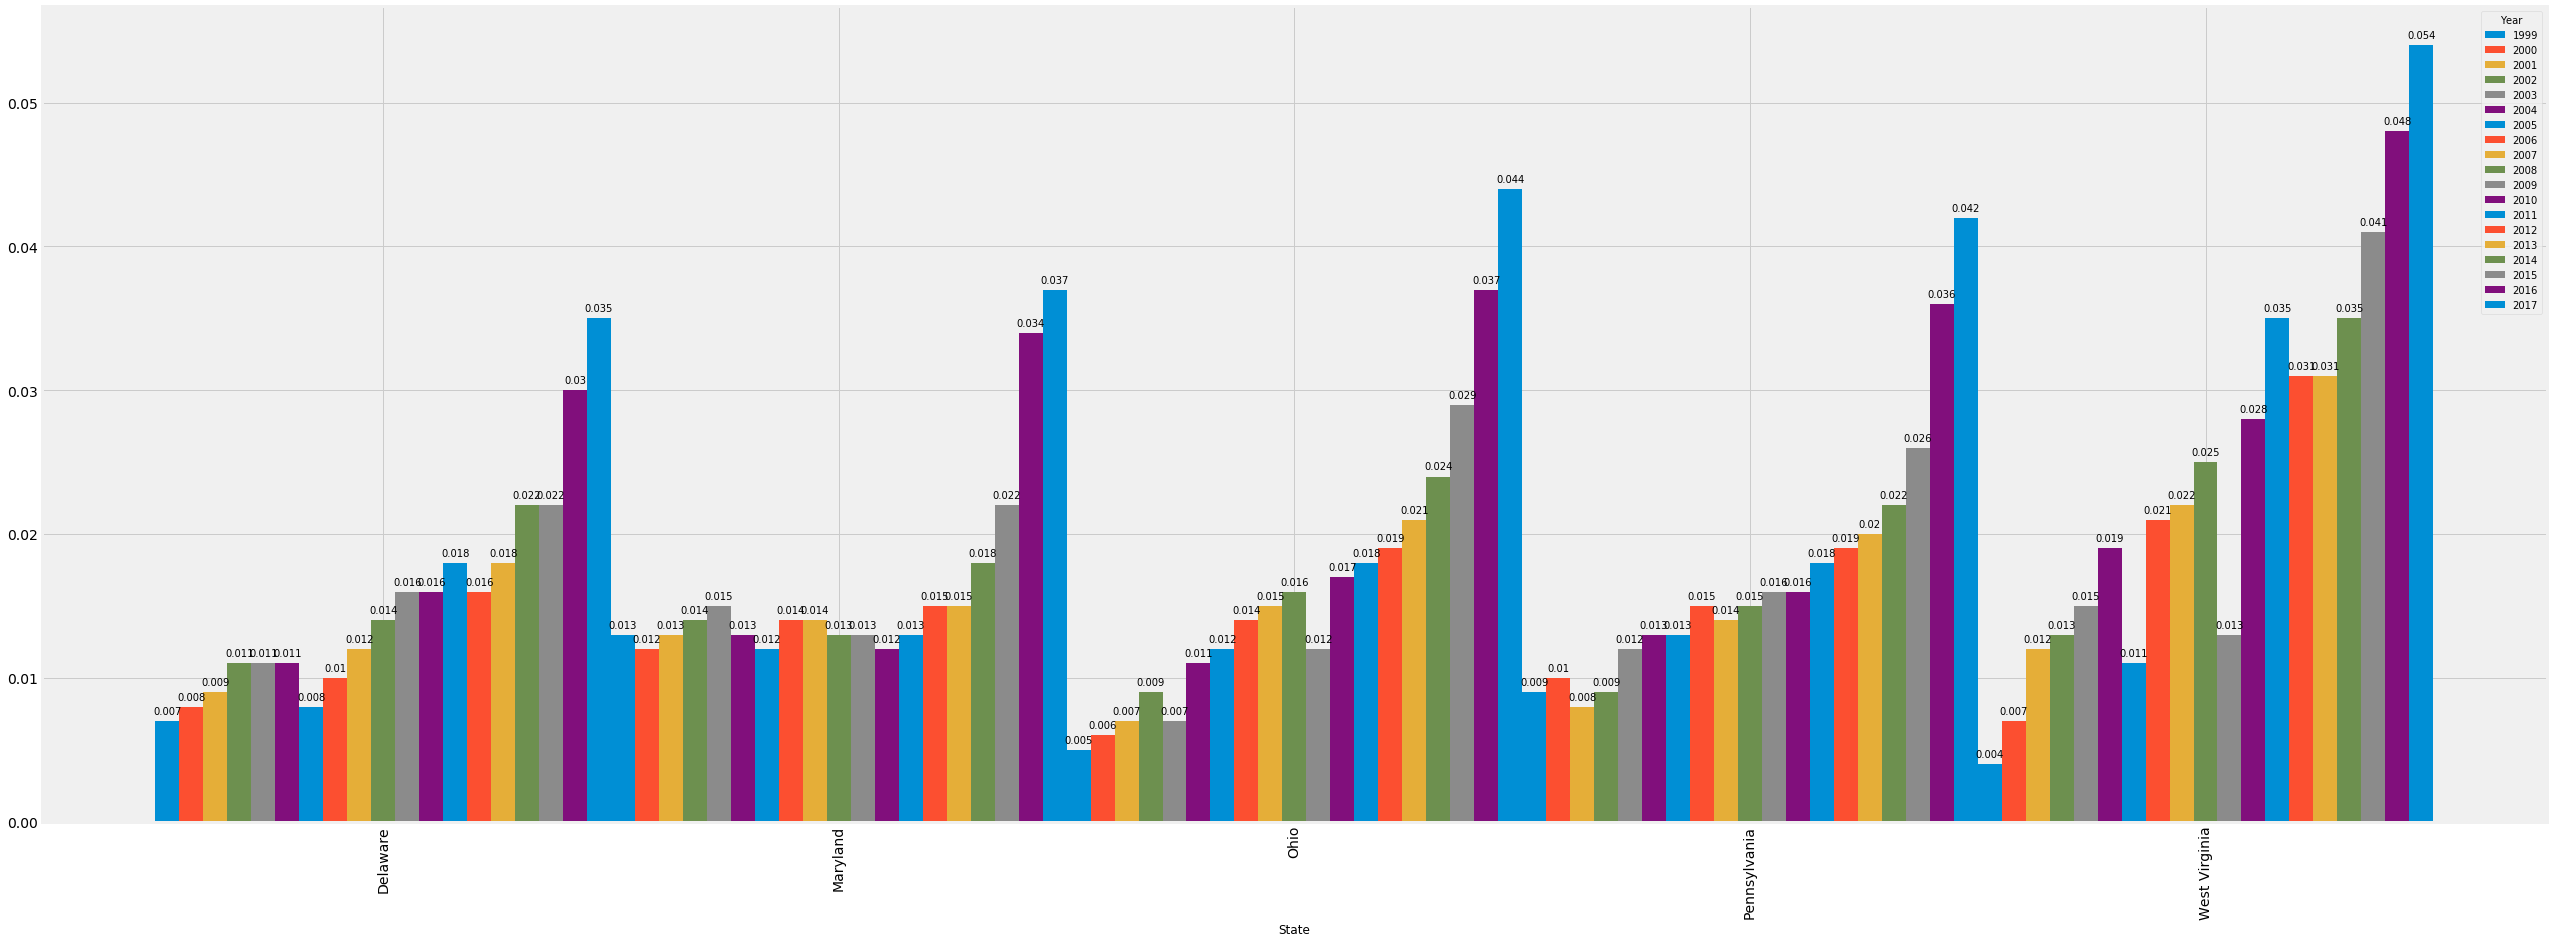

In [6]:
topdeaths = ['West Virginia', 'Ohio', 'Pennsylvania', 'Maryland', 'Delaware']
dfPlotTopFive = dfDeathTimeLine.loc[dfDeathTimeLine['State'].isin(topdeaths)]
print("---------------------------------------------------")
print("Top 5 states death rates from 1999-2017")
print('West Virginia, Ohio, Pennsylvania, Maryland, Delaware')
print("---------------------------------------------------")

axtopfive = dfPlotTopFive.pivot(index='State', columns='Year', values='percentage_deaths').plot(kind='bar', width=1, figsize=(40,15), fontsize=14)
for p in axtopfive.patches:
    b = p.get_bbox()
    val = b.y1    
    axtopfive.annotate(val, ((b.x0 + b.x1)/2, b.y1), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



In [7]:
print("---------------------------------------------------")
print("Statistics for top 5 overdose mortality rate 1999-2017: West Virgina")
print("---------------------------------------------------")
dfPlotTopFive[dfPlotTopFive['State'] == 'West Virginia'] 

---------------------------------------------------
Statistics for top 5 overdose mortality rate 1999-2017: West Virgina
---------------------------------------------------


,State,Year,Deaths,Population,percentage_deaths
824,West Virginia,1999,80,1811799,0.004
825,West Virginia,2000,122,1808344,0.007
826,West Virginia,2001,217,1801481,0.012
827,West Virginia,2002,237,1805414,0.013
828,West Virginia,2003,279,1812295,0.015
829,West Virginia,2004,347,1816438,0.019
830,West Virginia,2005,197,1820492,0.011
831,West Virginia,2006,378,1827912,0.021
832,West Virginia,2007,405,1834052,0.022
833,West Virginia,2008,468,1840310,0.025


In [8]:
print("---------------------------------------------------")
print("Statistics for top 5 overdose mortality rate 1999-2017: Ohio")
print("---------------------------------------------------")
dfPlotTopFive[dfPlotTopFive['State'] == 'Ohio'] 

---------------------------------------------------
Statistics for top 5 overdose mortality rate 1999-2017: Ohio
---------------------------------------------------


,State,Year,Deaths,Population,percentage_deaths
599,Ohio,1999,534,11335454,0.005
600,Ohio,2000,625,11353140,0.006
601,Ohio,2001,808,11387404,0.007
602,Ohio,2002,1025,11407889,0.009
603,Ohio,2003,852,11434788,0.007
604,Ohio,2004,1266,11452251,0.011
605,Ohio,2005,1382,11463320,0.012
606,Ohio,2006,1606,11481213,0.014
607,Ohio,2007,1691,11500468,0.015
608,Ohio,2008,1811,11515391,0.016


In [9]:
print("---------------------------------------------------")
print("Statistics for top 5 overdose mortality rate 1999-2017: Pennsylvania")
print("---------------------------------------------------")
dfPlotTopFive[dfPlotTopFive['State'] == 'Pennsylvania'] 

---------------------------------------------------
Statistics for top 5 overdose mortality rate 1999-2017: Pennsylvania
---------------------------------------------------


,State,Year,Deaths,Population,percentage_deaths
652,Pennsylvania,1999,1049,12263805,0.009
653,Pennsylvania,2000,1215,12281054,0.010
654,Pennsylvania,2001,1021,12298970,0.008
655,Pennsylvania,2002,1159,12331031,0.009
656,Pennsylvania,2003,1441,12374658,0.012
657,Pennsylvania,2004,1600,12410722,0.013
658,Pennsylvania,2005,1680,12449990,0.013
659,Pennsylvania,2006,1834,12510809,0.015
660,Pennsylvania,2007,1812,12563937,0.014
661,Pennsylvania,2008,1898,12612285,0.015


In [10]:
print("---------------------------------------------------")
print("Statistics for top 5 overdose mortality rate 1999-2017: Maryland")
print("---------------------------------------------------")
dfPlotTopFive[dfPlotTopFive['State'] == 'Maryland'] 

---------------------------------------------------
Statistics for top 5 overdose mortality rate 1999-2017: Maryland
---------------------------------------------------


,State,Year,Deaths,Population,percentage_deaths
342,Maryland,1999,660,5254509,0.013
343,Maryland,2000,657,5296486,0.012
344,Maryland,2001,676,5374691,0.013
345,Maryland,2002,759,5440389,0.014
346,Maryland,2003,834,5496269,0.015
347,Maryland,2004,721,5546935,0.013
348,Maryland,2005,696,5592379,0.012
349,Maryland,2006,805,5627367,0.014
350,Maryland,2007,807,5653408,0.014
351,Maryland,2008,731,5684965,0.013


In [11]:
print("---------------------------------------------------")
print("Statistics for top 5 overdose mortality rate 1999-2017: Delaware")
print("---------------------------------------------------")
dfPlotTopFive[dfPlotTopFive['State'] == 'Delaware'] 

---------------------------------------------------
Statistics for top 5 overdose mortality rate 1999-2017: Delaware
---------------------------------------------------


,State,Year,Deaths,Population,percentage_deaths
119,Delaware,1999,55,774990,0.007
120,Delaware,2000,60,783600,0.008
121,Delaware,2001,70,795699,0.009
122,Delaware,2002,85,806169,0.011
123,Delaware,2003,88,818003,0.011
124,Delaware,2004,92,830803,0.011
125,Delaware,2005,67,845150,0.008
126,Delaware,2006,83,859268,0.010
127,Delaware,2007,102,871749,0.012
128,Delaware,2008,125,883874,0.014


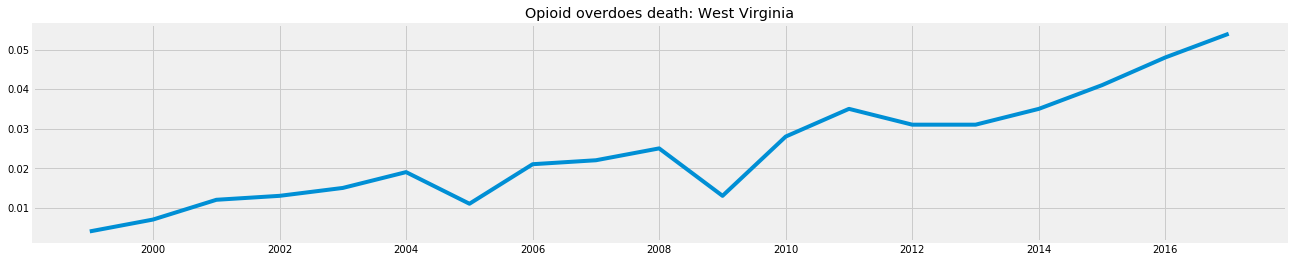

---------------------------------------------------
Auto Regressive Moving Average(ARMA): West Virginia
Projections inconclusive due to small datasets but does not seem to converge close to 0
Metrics might change if there are mandates and bans on opioid prescriptions
---------------------------------------------------
(0, 0) :  -81.20104298788108
(1, 0) :  -80.39935260754748
(2, 0) :  -80.84729586776814
(3, 0) :  -78.84906347213078
(4, 0) :  -18.817731392530618
Best ARMA (0, 0) model - AIC:-81.20104298788108


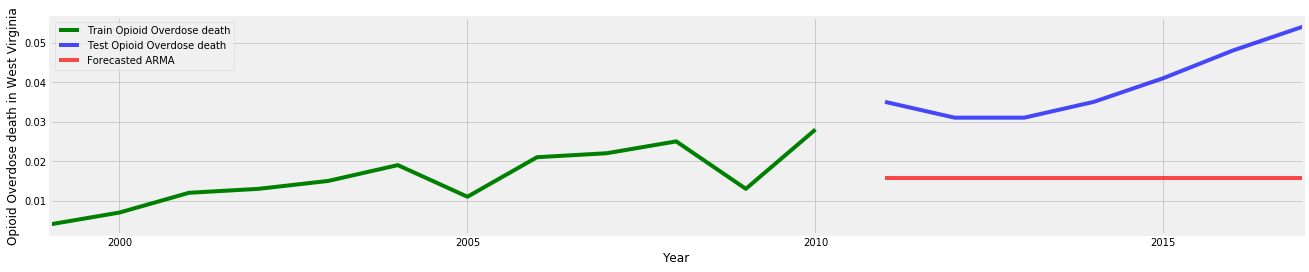

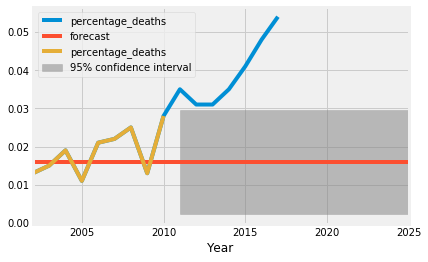

,Method,RMSE,MAPE
0,Auto Regressive Moving Average,0.025,0.581


In [12]:
# I don't have a good sampling of this data- very few slices of testing and training
# The tendency is still towards > 2%
# ARMA results are better than ARIMA
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import datetime
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# West Virginia Number 1 in 2014
dfPlotTopFiveWV = dfPlotTopFive[dfPlotTopFive['State'] == 'West Virginia'].iloc[:, [1, -1]]
# Convert Year to datetime to get the right plot- it is current an Integer - plot will contain integers
dfPlotTopFiveWV['Year'] = pd.to_datetime(dfPlotTopFiveWV.Year, format='%Y')
#print(dfPlotTopFiveWV.dtypes)
dfPlotTopFiveWV.set_index('Year', inplace=True)

# plot results
plt.figure(figsize=(20,4))
plt.title('Opioid overdoes death: West Virginia')
plt.plot(dfPlotTopFiveWV)
plt.show()

train = (dfPlotTopFiveWV[dfPlotTopFiveWV.index < '2011'])
test = (dfPlotTopFiveWV[dfPlotTopFiveWV.index >= '2011'])

print("---------------------------------------------------")
print("Auto Regressive Moving Average(ARMA): West Virginia")
print("Projections inconclusive due to small datasets but does not seem to converge close to 0")
print("Metrics might change if there are mandates and bans on opioid prescriptions")
print("---------------------------------------------------")
# Define the p and q parameters to take any value between 0 and 2
p = range(0, 5)
q = range(0, 1)
# Generate all different combinations of p,q
pq = list(itertools.product(p,q))
#Grid Search to get the best p,q parameter
best_aic = np.inf
best_pq = None
temp_model = None
for param in pq:
    temp_model = ARMA(train, order=param)
    results = temp_model.fit()
    print(param, ": ", results.aic)
    if results.aic < best_aic:
        best_aic = results.aic
        best_pq = param

print("Best ARMA {} model - AIC:{}".format(best_pq,best_aic))
        
# using the best parameter in the model
model = ARMA(train, order=(0,0))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['percentage_deaths'], predictions))
rmse = round(rmse, 3)

# Mean Absolute Percentage Error
abs_error = np.abs(test['percentage_deaths']- predictions)
actual = test['percentage_deaths']
mape = np.round(np.mean(abs_error/actual),3)
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'RMSE': [rmse]})
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]


#Plot of CO2 gas emission with Test and Prediction along with Train
axis = train['percentage_deaths'].plot(label='Train Opioid Overdose death', figsize=(20, 4), color = 'green')
test['percentage_deaths'].plot(ax=axis, label='Test Opioid Overdose death', alpha=0.7, color = 'blue')
predictions.plot(ax=axis, label='Forecasted ARMA', alpha=0.7, color = 'red')
axis.set_xlabel('Year')
axis.set_ylabel('Opioid Overdose death in West Virginia')
plt.legend(loc='best')
plt.show()
plt.close()

# YIKES!!!! required - more granularity in data
pred_uc = model_fit.forecast(steps=10, alpha=0.05)
#print(pred_uc)
fig, ax = plt.subplots()
ax = dfPlotTopFiveWV.ix['2002':].plot(ax=ax)
fig = model_fit.plot_predict('2002', '2025', dynamic=True, ax=ax)
plt.show()

resultsDf


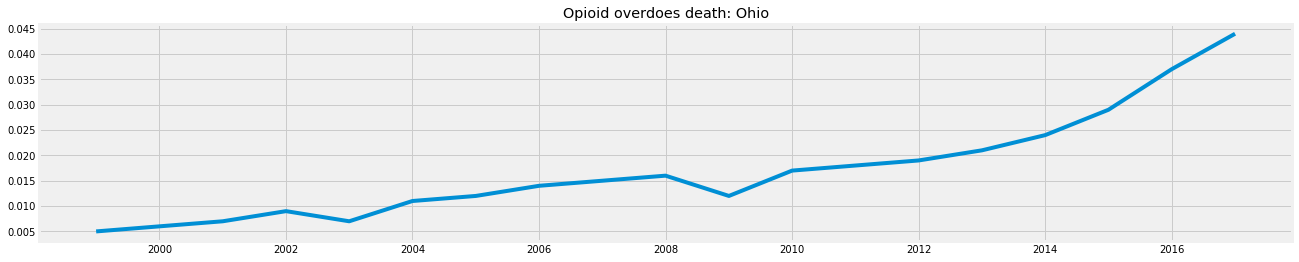

---------------------------------------------------
Auto Regressive Moving Average(ARMA): Ohio
Projections inconclusive due to small datasets but does not seem to converge close to 0
Metrics might change if there are mandates and bans on opioid prescriptions
---------------------------------------------------
(0, 0) :  -94.91161841838004
(1, 0) :  -102.26982714399372
(2, 0) :  -101.68709255910423
(3, 0) :  -100.84565823297686
(4, 0) :  -100.01311874812765
Best ARMA (1, 0) model - AIC:-102.26982714399372


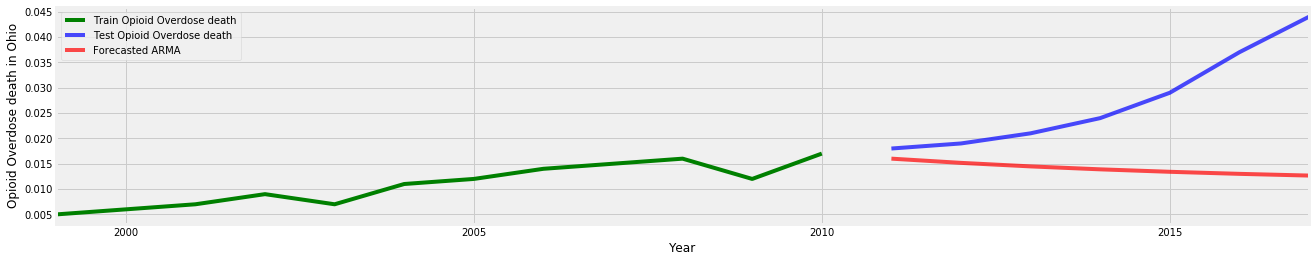

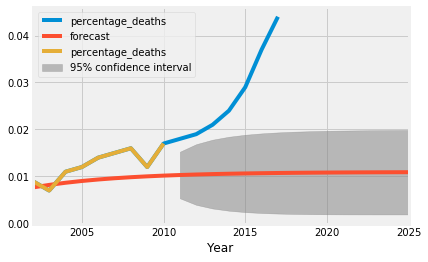

,Method,RMSE,MAPE
0,Auto Regressive Moving Average,0.017,0.42


In [13]:
# Ohio: Number 2 in 2017
dfPlotTopFiveOH = dfPlotTopFive[dfPlotTopFive['State'] == 'Ohio'].iloc[:, [1, -1]]
# Convert Year to datetime to get the right plot- it is current an Integer - plot will contain integers
dfPlotTopFiveOH['Year'] = pd.to_datetime(dfPlotTopFiveOH.Year, format='%Y')
#print(dfPlotTopFiveOH.dtypes)
dfPlotTopFiveOH.set_index('Year', inplace=True)

# plot results
plt.figure(figsize=(20,4))
plt.title('Opioid overdoes death: Ohio')
plt.plot(dfPlotTopFiveOH)
plt.show()

train = (dfPlotTopFiveOH[dfPlotTopFiveOH.index < '2011'])
test = (dfPlotTopFiveOH[dfPlotTopFiveOH.index >= '2011'])

print("---------------------------------------------------")
print("Auto Regressive Moving Average(ARMA): Ohio")
print("Projections inconclusive due to small datasets but does not seem to converge close to 0")
print("Metrics might change if there are mandates and bans on opioid prescriptions")
print("---------------------------------------------------")
# Define the p and q parameters to take any value 
p = range(0, 5)
q = range(0, 1)
# Generate all different combinations of p,q
pq = list(itertools.product(p,q))
#Grid Search to get the best p,q parameter
best_aic = np.inf
best_pq = None
temp_model = None
for param in pq: 
    temp_model = ARMA(train, order=param)
    results = temp_model.fit()
    print(param, ": ", results.aic)
    if results.aic < best_aic:
        best_aic = results.aic
        best_pq = param

print("Best ARMA {} model - AIC:{}".format(best_pq, best_aic))
# using the best parameter in the model
model = ARMA(train, order=(1,0))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['percentage_deaths'], predictions))
rmse = round(rmse, 3)

# Mean Absolute Percentage Error
abs_error = np.abs(test['percentage_deaths']- predictions)
actual = test['percentage_deaths']
mape = np.round(np.mean(abs_error/actual),3)
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'RMSE': [rmse]})
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]


#Plot of CO2 gas emission with Test and Prediction along with Train
axis = train['percentage_deaths'].plot(label='Train Opioid Overdose death', figsize=(20, 4), color = 'green')
test['percentage_deaths'].plot(ax=axis, label='Test Opioid Overdose death', alpha=0.7, color = 'blue')
predictions.plot(ax=axis, label='Forecasted ARMA', alpha=0.7, color = 'red')
axis.set_xlabel('Year')
axis.set_ylabel('Opioid Overdose death in Ohio')
plt.legend(loc='best')
plt.show()
plt.close()

# YIKES!!!! required - more granularity in data
pred_uc = model_fit.forecast(steps=10, alpha=0.05)
#print(pred_uc)
fig, ax = plt.subplots()
ax = dfPlotTopFiveOH.ix['2002':].plot(ax=ax)
fig = model_fit.plot_predict('2002', '2025', dynamic=True, ax=ax)
plt.show()

resultsDf

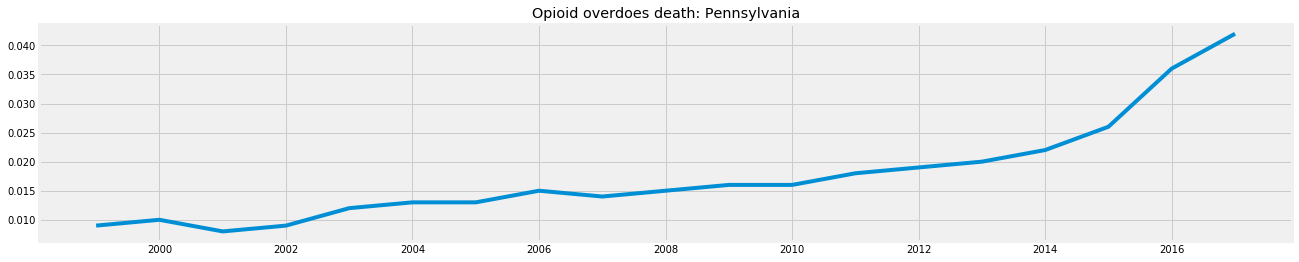

---------------------------------------------------
Auto Regressive Moving Average(ARMA): Pennsylvania
Projections inconclusive due to small datasets but does not seem to converge close to 0
Metrics might change if there are mandates and bans on opioid prescriptions
---------------------------------------------------
(0, 0) :  -103.42016761791295
(1, 0) :  -115.85915450944105
(2, 0) :  -113.90085636733812
(3, 0) :  -111.9252371783628
(4, 0) :  -112.7355790935261
Best ARMA (1, 0) model - AIC:-115.85915450944105


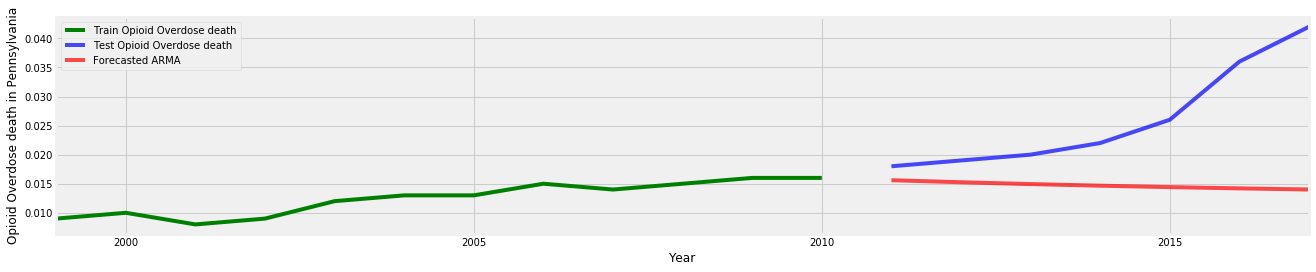

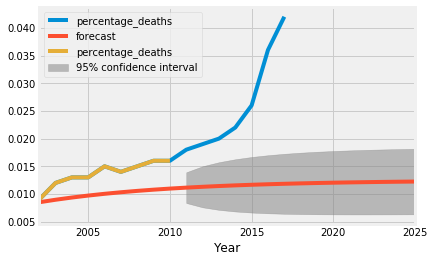

,Method,RMSE,MAPE
0,Auto Regressive Moving Average,0.015,0.376


In [14]:
# Pennsylvania: Number 3 in 2017
dfPlotTopFivePA = dfPlotTopFive[dfPlotTopFive['State'] == 'Pennsylvania'].iloc[:, [1, -1]]
# Convert Year to datetime to get the right plot- it is current an Integer - plot will contain integers
dfPlotTopFivePA['Year'] = pd.to_datetime(dfPlotTopFivePA.Year, format='%Y')
#print(dfPlotTopFivePA.dtypes)
dfPlotTopFivePA.set_index('Year', inplace=True)

# plot results
plt.figure(figsize=(20,4))
plt.title('Opioid overdoes death: Pennsylvania')
plt.plot(dfPlotTopFivePA)
plt.show()

train = (dfPlotTopFivePA[dfPlotTopFivePA.index < '2011'])
test = (dfPlotTopFivePA[dfPlotTopFivePA.index >= '2011'])

print("---------------------------------------------------")
print("Auto Regressive Moving Average(ARMA): Pennsylvania")
print("Projections inconclusive due to small datasets but does not seem to converge close to 0")
print("Metrics might change if there are mandates and bans on opioid prescriptions")
print("---------------------------------------------------")
# Define the p and q parameters to take any value between 0 and 2
p = range(0, 5)
q = range(0, 1)
# Generate all different combinations of p,q
pq = list(itertools.product(p,q))
#Grid Search to get the best p,q parameter
best_aic = np.inf
best_pq = None
temp_model = None
for param in pq: 
    temp_model = ARMA(train, order=param)
    results = temp_model.fit()
    print(param, ": ", results.aic)
    if results.aic < best_aic:
        best_aic = results.aic
        best_pq = param

print("Best ARMA {} model - AIC:{}".format(best_pq, best_aic))
# using the best parameter in the model
model = ARMA(train, order=(1,0))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['percentage_deaths'], predictions))
rmse = round(rmse, 3)

# Mean Absolute Percentage Error
abs_error = np.abs(test['percentage_deaths']- predictions)
actual = test['percentage_deaths']
mape = np.round(np.mean(abs_error/actual),3)
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'RMSE': [rmse]})
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]


#Plot of CO2 gas emission with Test and Prediction along with Train
axis = train['percentage_deaths'].plot(label='Train Opioid Overdose death', figsize=(20, 4), color = 'green')
test['percentage_deaths'].plot(ax=axis, label='Test Opioid Overdose death', alpha=0.7, color = 'blue')
predictions.plot(ax=axis, label='Forecasted ARMA', alpha=0.7, color = 'red')
axis.set_xlabel('Year')
axis.set_ylabel('Opioid Overdose death in Pennsylvania')
plt.legend(loc='best')
plt.show()
plt.close()

# YIKES!!!! required - more granularity in data
pred_uc = model_fit.forecast(steps=10, alpha=0.05)
#print(pred_uc)
fig, ax = plt.subplots()
ax = dfPlotTopFivePA.ix['2002':].plot(ax=ax)
fig = model_fit.plot_predict('2002', '2025', dynamic=True, ax=ax)
plt.show()

resultsDf

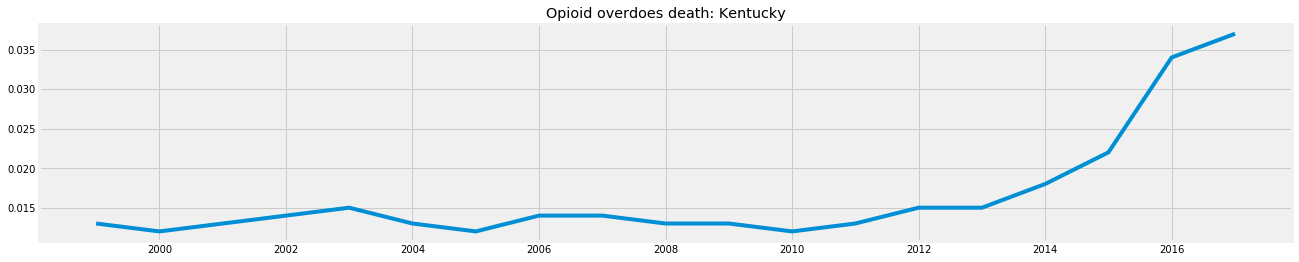

---------------------------------------------------
Auto Regressive Moving Average(ARMA): Maryland
Projections inconclusive due to small datasets but does not seem to converge close to 0
Metrics might change if there are mandates and bans on opioid prescriptions
---------------------------------------------------
(0, 0) :  -130.32627920029478
(1, 0) :  -128.63144004975223
(2, 0) :  -131.59491312304587
(3, 0) :  -130.54949426413143
(4, 0) :  -130.22975307111105
Best ARMA (2, 0) model - AIC:-131.59491312304587


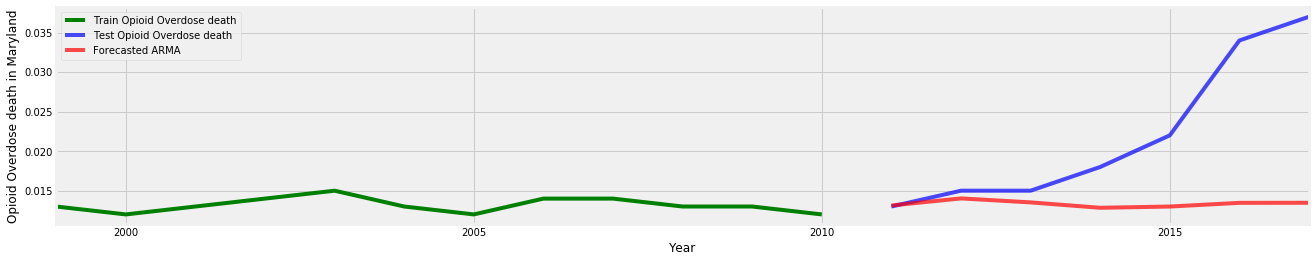

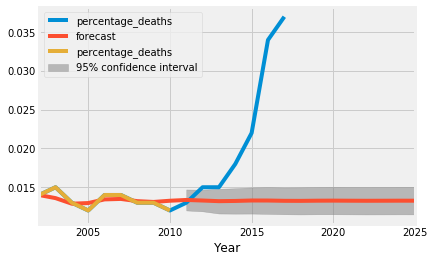

,Method,RMSE,MAPE
0,Auto Regressive Moving Average,0.012,0.301


In [15]:
# Maryland
dfPlotTopFiveMD = dfPlotTopFive[dfPlotTopFive['State'] == 'Maryland'].iloc[:, [1, -1]]
# Convert Year to datetime to get the right plot- it is current an Integer - plot will contain integers
dfPlotTopFiveMD['Year'] = pd.to_datetime(dfPlotTopFiveMD.Year, format='%Y')
#print(dfPlotTopFiveKentucky.dtypes)
dfPlotTopFiveMD.set_index('Year', inplace=True)

# plot results
plt.figure(figsize=(20,4))
plt.title('Opioid overdoes death: Kentucky')
plt.plot(dfPlotTopFiveMD)
plt.show()

trainK = (dfPlotTopFiveMD[dfPlotTopFiveMD.index < '2011'])
testK = (dfPlotTopFiveMD[dfPlotTopFiveMD.index >= '2011'])
#dfPlotTopFiveMD
#print(trainK.dtypes)
#testK

print("---------------------------------------------------")
print("Auto Regressive Moving Average(ARMA): Maryland")
print("Projections inconclusive due to small datasets but does not seem to converge close to 0")
print("Metrics might change if there are mandates and bans on opioid prescriptions")
print("---------------------------------------------------")
# Define the p and q parameters to take any value between 0 and 2
p = range(0, 5)
q = range(0, 1)
# Generate all different combinations of p,q
pq = list(itertools.product(p,q))
#Grid Search to get the best p,q parameter
best_aic = np.inf
best_pq = None
temp_model = None
for param in pq: 
    temp_model = ARMA(trainK, order=param)
    results = temp_model.fit()
    print(param, ": ", results.aic)
    if results.aic < best_aic:
        best_aic = results.aic
        best_pq = param

print("Best ARMA {} model - AIC:{}".format(best_pq, best_aic))
# using the best parameter in the model
model = ARMA(trainK, order=(2,0))
model_fit = model.fit()

predictions = model_fit.predict(start=len(trainK), end=len(trainK)+len(testK)-1)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(testK['percentage_deaths'], predictions))
rmse = round(rmse, 3)

# Mean Absolute Percentage Error
abs_error = np.abs(testK['percentage_deaths']- predictions)
actual = testK['percentage_deaths']
mape = np.round(np.mean(abs_error/actual),3)
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'RMSE': [rmse]})
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]


#Plot of CO2 gas emission with Test and Prediction along with Train
axis = trainK['percentage_deaths'].plot(label='Train Opioid Overdose death', figsize=(20, 4), color = 'green')
testK['percentage_deaths'].plot(ax=axis, label='Test Opioid Overdose death', alpha=0.7, color = 'blue')
predictions.plot(ax=axis, label='Forecasted ARMA', alpha=0.7, color = 'red')
axis.set_xlabel('Year')
axis.set_ylabel('Opioid Overdose death in Maryland')
plt.legend(loc='best')
plt.show()
plt.close()

# YIKES!!!! required - more granularity in data
pred_uc = model_fit.forecast(steps=10, alpha=0.05)
#print(pred_uc)
fig, ax = plt.subplots()
ax = dfPlotTopFiveMD.ix['2002':].plot(ax=ax)
fig = model_fit.plot_predict('2002', '2025', dynamic=True, ax=ax)
plt.show()

resultsDf

In [16]:
"""
import csv
# Convert tab delimited text file to csv
txt_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_DRUG_17/PartD_Prescriber_PUF_NPI_Drug_17.txt"
csv_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_DRUG_17/PartD_Prescriber_PUF_NPI_Drug_17.csv"


in_txt = csv.reader(open(txt_file, "r", errors='ignore'), delimiter = '\t')
out_csv = csv.writer(open(csv_file, 'w'))

out_csv.writerows(in_txt)

print("written")

"""

'\nimport csv\n# Convert tab delimited text file to csv\ntxt_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_DRUG_17/PartD_Prescriber_PUF_NPI_Drug_17.txt"\ncsv_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_DRUG_17/PartD_Prescriber_PUF_NPI_Drug_17.csv"\n\n\nin_txt = csv.reader(open(txt_file, "r", errors=\'ignore\'), delimiter = \'\t\')\nout_csv = csv.writer(open(csv_file, \'w\'))\n\nout_csv.writerows(in_txt)\n\nprint("written")\n\n'

In [17]:
"""
import pandas as pd
import csv
csv_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_DRUG_17/PartD_Prescriber_PUF_NPI_Drug_17.csv"

dfpartD_prescriber = pd.read_csv(csv_file, index_col=None).fillna(value=0)
#print(dfpartD_prescriber.shape())

dfpartD_prescriber.head()


#reshaped_df = dfpartD_prescriber.melt(id_vars=['Day'], var_name='Company', value_name='Closing Price')
"""


'\nimport pandas as pd\nimport csv\ncsv_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_DRUG_17/PartD_Prescriber_PUF_NPI_Drug_17.csv"\n\ndfpartD_prescriber = pd.read_csv(csv_file, index_col=None).fillna(value=0)\n#print(dfpartD_prescriber.shape())\n\ndfpartD_prescriber.head()\n\n\n#reshaped_df = dfpartD_prescriber.melt(id_vars=[\'Day\'], var_name=\'Company\', value_name=\'Closing Price\')\n'

In [18]:
"""
import csv
# Convert tab delimited text file to csv
txt_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_17/PartD_Prescriber_PUF_NPI_17.txt"
csv_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_17/PartD_Prescriber_PUF_NPI_17.csv"


in_txt = csv.reader(open(txt_file, "r", errors='ignore'), delimiter = '\t')
out_csv = csv.writer(open(csv_file, 'w'))

out_csv.writerows(in_txt)

print("written")
"""

'\nimport csv\n# Convert tab delimited text file to csv\ntxt_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_17/PartD_Prescriber_PUF_NPI_17.txt"\ncsv_file = r"C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/PartD_Prescriber_PUF_NPI_17/PartD_Prescriber_PUF_NPI_17.csv"\n\n\nin_txt = csv.reader(open(txt_file, "r", errors=\'ignore\'), delimiter = \'\t\')\nout_csv = csv.writer(open(csv_file, \'w\'))\n\nout_csv.writerows(in_txt)\n\nprint("written")\n'

In [19]:
# dfPrescriber is the main dataframe
# Checking for nulls
print("---------------------------------------------------")
print("Checking for NULLs and NAs in main dataset")
print("---------------------------------------------------")
dfPrescriber.isnull().sum()

---------------------------------------------------
Checking for NULLs and NAs in main dataset
---------------------------------------------------


npi                               0
Gender                            0
State                             0
Credentials                       0
Specialty                         0
ABILIFY.MAINTENA                  0
ACARBOSE                          0
ACETAMINOPHEN.CODEINE             0
ACETAZOLAMIDE                     0
ACYCLOVIR                         0
ADVAIR.DISKUS                     0
ADVAIR.HFA                        0
ALBUTEROL.SULFATE                 0
ALCOHOL.PADS                      0
ALCOHOL.PREP.PADS                 0
ALENDRONATE.SODIUM                0
ALFUZOSIN.HCL.ER                  0
ALLOPURINOL                       0
ALPHAGAN.P                        0
ALPRAZOLAM                        0
AMANTADINE                        0
AMIODARONE.HCL                    0
AMITIZA                           0
AMITRIPTYLINE.HCL                 0
AMLODIPINE.BESYLATE               0
AMLODIPINE.BESYLATE.BENAZEPRIL    0
AMLODIPINE.OLMESARTAN             0
AMLODIPINE.VALSARTAN        

In [20]:
print("---------------------------------------------------")
print("Number of columns and rows in the maind dataset")
print("---------------------------------------------------")
dfPrescriber.shape

---------------------------------------------------
Number of columns and rows in the maind dataset
---------------------------------------------------


(350000, 606)

In [21]:
# dfPrescriber.head()
# dfPrescriber.count()
# PR, AE, ZZ, GU, AA or VI not included in the overdose section
# Remove states that does not give us any useful information
remove_state = ['PR', 'AE', 'ZZ', 'GU', 'AA', 'VI']
dfPrescriber = dfPrescriber[~dfPrescriber['State'].isin(remove_state)]
dfOpioidPresc = dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1]
print("________________________________________________")
print("Prescribers' Unique States")
print("________________________________________________")
print(list(pd.Series(dfPrescriber.State.unique()).sort_values()))
print("________________________________________________")
print("Overdoses state")
print("________________________________________________")
print(list(pd.Series(dfOverdoses.Abbrev.unique()).sort_values()))
print("________________________________________________")
print("Prescribers' Speciality whose patients have the potential to overdose")
print("________________________________________________")
print(list(dfOpioidPresc.Specialty.unique()))



________________________________________________
Prescribers' Unique States
________________________________________________
['AK', 'AL', 'AP', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'XX']
________________________________________________
Overdoses state
________________________________________________
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
________________________________________________
Prescribers' Speciality whose patients have the potential to overdose
__________

---------------------------------------------------
Opioid drug columns from dataset along with Gender, State, Speciality
---------------------------------------------------
['Gender', 'State', 'Specialty', 'ACETAMINOPHEN.CODEINE', 'BUPRENORPHINE.HCL', 'BUTRANS', 'ENDOCET', 'FENTANYL', 'HYDROCODONE.ACETAMINOPHEN', 'HYDROCODONE.IBUPROFEN', 'HYDROMORPHONE.HCL', 'METHADONE.HCL', 'MORPHINE.SULFATE', 'MORPHINE.SULFATE.ER', 'OPANA.ER', 'OXYCODONE.ACETAMINOPHEN', 'OXYCODONE.HCL', 'OXYCODONE.HCL.ER', 'OXYCONTIN', 'TRAMADOL.HCL', 'TRAMADOL.HCL.ACETAMINOPHEN', 'TRAMADOL.HCL.ER']
Total Prescriptuon per State:  (55, 2)
Total Prescriptuon per State & Gender:  (108, 3)
Merged dataset with population for State totals:  (50, 4)
---------------------------------------------------
Percentage prescriptions by State
---------------------------------------------------


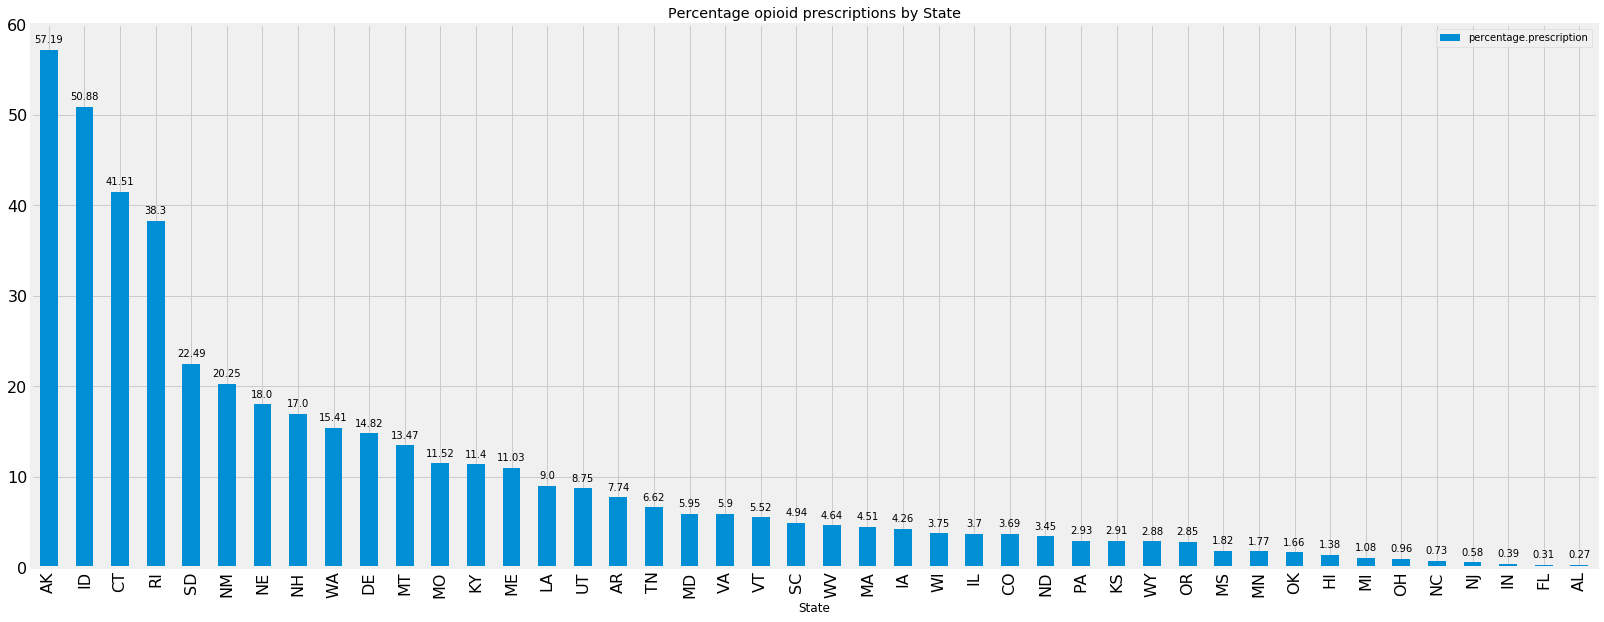

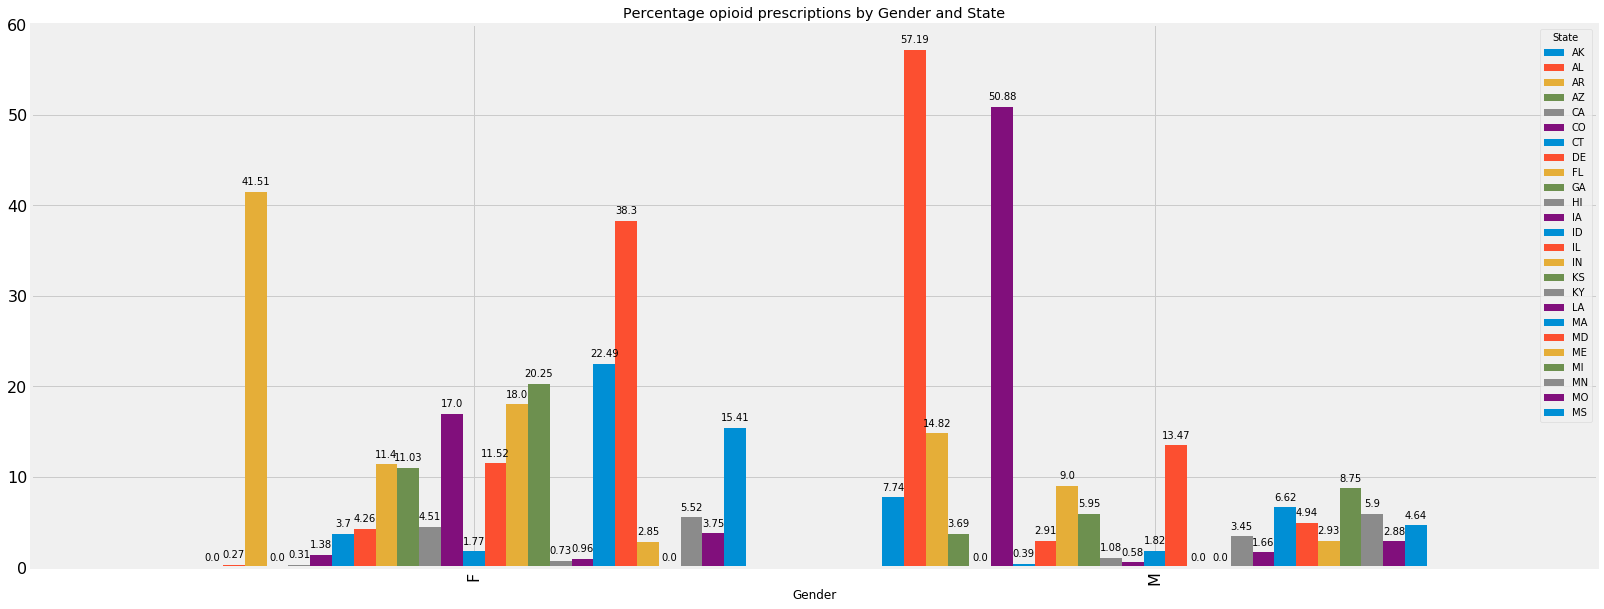

In [22]:
# Pick opioid prescribers by state and check to see if the overdose details tallies with the prescription details
import re
# Remove spaces as it is the column name 
# Matching name in opioid file with the column names in prescriber.csv AMIODARONE.HCL
opioid_name = dfOpioids['drug_name'].apply(lambda x:re.sub("\ |-", ".", str(x)))
#for s in opioid_name:
    #print(s)

# Opioid prescriber tells us if the doctor prescribes opioids
# Data set contains columns that are both opioids and non opioids 
# remove non opioid columns from the prescription dataset
columns = dfPrescriber.columns
add_cols = set(columns).intersection(set(opioid_name))
lst_cols_add = ['State', 'Gender', 'Specialty']
    
opioid_cols=[]
for col in columns:
    if col in add_cols:
        opioid_cols.append(col)
    elif col in lst_cols_add:
        opioid_cols.append(col)
    else:
        pass
        
print("---------------------------------------------------")
print("Opioid drug columns from dataset along with Gender, State, Speciality")
print("---------------------------------------------------")
print(list(opioid_cols))

# Gather the opioid columns along with State and Gender
dfOpioidsSub = dfPrescriber[opioid_cols]

# Group by State column
dfOpioidsSub['total_prescription'] = dfOpioidsSub.iloc[:, 2:13].sum(axis=1)
dfPrescriptions = dfOpioidsSub[['State', 'total_prescription']].groupby(['State']).sum().reset_index()
print("Total Prescriptuon per State: " , dfPrescriptions.shape)

#group by gender and state column
dfPrescriptionsGender = dfOpioidsSub[['State', 'Gender', 'total_prescription']].groupby(['State', 'Gender']).sum().reset_index()
print("Total Prescriptuon per State & Gender: ", dfPrescriptionsGender.shape)


# Merge with overdose dataframe to grab the population field
dfStatePop = dfOverdoses[['Population', 'Abbrev', 'LAT', 'LNG']]
dfStatePop = dfStatePop.rename(columns={ dfStatePop.columns[1]: "State" })
print("Merged dataset with population for State totals: ", dfStatePop.shape)
#print(dfStatePop.dtypes)


# total prescription without gender
dfTotalPreByState = dfStatePop.merge(dfPrescriptions)
dfTotalPreByState['percentage.prescription'] =  round((dfPrescriptions.total_prescription * 100) / dfStatePop.Population, 2)


# Total prescriptions by gender
dfTotalPreByStateGender = dfStatePop.merge(dfPrescriptionsGender)
dfTotalPreByStateGender['percentage.prescription'] =  round((dfPrescriptions.total_prescription * 100) / dfStatePop.Population, 2)


# Bar charts
# Prescriptions without gender
dfplot_presc = dfTotalPreByState[['State', 'percentage.prescription']].sort_values(['percentage.prescription'], ascending=False)
dfplot_presc = dfplot_presc[dfplot_presc['percentage.prescription'] > 0.2] 
#print (dfplot_presc.dtypes)
ax = dfplot_presc.plot(x='State', y='percentage.prescription', kind='bar', figsize=(25,10), fontsize=16, title="Percentage opioid prescriptions by State")
for p in ax.patches:
    b = p.get_bbox()
    val = b.y1    
    ax.annotate(val, ((b.x0 + b.x1)/2, b.y1), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


# prescriptions by gender
dfplot_presc_gender = dfTotalPreByStateGender[['State', 'Gender', 'percentage.prescription']].sort_values(['percentage.prescription'], ascending=False)
dfplot_presc_gender = dfplot_presc_gender[dfplot_presc_gender['percentage.prescription'] > 0.2] 
axg = dfplot_presc_gender.pivot(index='Gender', columns='State', values='percentage.prescription').plot(kind='bar', width=0.8, figsize=(25,10), fontsize=16, title="Percentage opioid prescriptions by Gender and State")
for p in axg.patches:
    b = p.get_bbox()
    val = b.y1    
    axg.annotate(val, ((b.x0 + b.x1)/2, b.y1), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

#Choropleth map for all prescriptions without gender specifications
print("---------------------------------------------------")
print("Percentage prescriptions by State")
print("---------------------------------------------------")
pres_map = folium.Map(location=[37.0902405, -95.7128906], zoom_start = 4, tiles = 'Mapbox Bright')

folium.Choropleth(geo_data = us_states_geo,
                       data = dfTotalPreByState,
                       hover_name="State",
                       columns = ['State', 'percentage.prescription'],
                       key_on = 'feature.id',
                       fill_color='OrRd',
                       fill_opacity=0.9,
                       nan_fill_color='#ffffff',
                       nan_fill_opacity=0.9,
                       highlight=True,
                       legend_name = 'Opioid Prescriptions').add_to(pres_map)

marker_cluster = MarkerCluster().add_to(pres_map) 

# Add markers over choropleth
for i in range(dfTotalPreByState.shape[0]):
    location = [dfTotalPreByState['LAT'][i], dfTotalPreByState['LNG'][i]]
    tooltip = "State:{}<br> Click for more".format(dfTotalPreByState["State"][i])
    folium.Marker(location,
                  popup="""
                  <i>Prescription: </i> <br> <b>{}</b> <br> 
                  <i>Population: </i><b><br>{}</b><br>
                  <i>Percentage Prescription by pop: </i><b><br>{}</b><br>""".format(
                    dfTotalPreByState['total_prescription'][i], 
                    dfTotalPreByState['Population'][i], 
                    round(dfTotalPreByState['percentage.prescription'][i],2)), 
                      tooltip=tooltip).add_to(marker_cluster)

pres_map



---------------------------------------------------
Total for each Opioid Prescription Column
Most prescribed drug: HYDROCODONE.ACETAMINOPHEN
THIS DATASET SEEMS TO ALIGN WITH THE FOLLOWING TRIVIA ON OPIOIDS
Trivia:
Hydrocodone is used to treat moderate to severe pain due to chronic condition, injury, or surgery. 
      It should only be taken as prescribed by the doctor because of the risk of addiction. 
      Because of the way it’s prescribed, hydrocodone appears more likely to be prescribed 
      compared to other opioids. It’s misused more than any other opioid in the United States. 
      The drug is already banned in European nations due to its abusive tendencies. (healthline.com)
---------------------------------------------------


,Opioid,total_prescribed
19,total_prescription,12794059
5,HYDROCODONE.ACETAMINOPHEN,9811122
16,TRAMADOL.HCL,5148042
12,OXYCODONE.ACETAMINOPHEN,3477561
13,OXYCODONE.HCL,2624139
10,MORPHINE.SULFATE.ER,1128850
0,ACETAMINOPHEN.CODEINE,1023436
4,FENTANYL,857408
15,OXYCONTIN,429940
8,METHADONE.HCL,384693


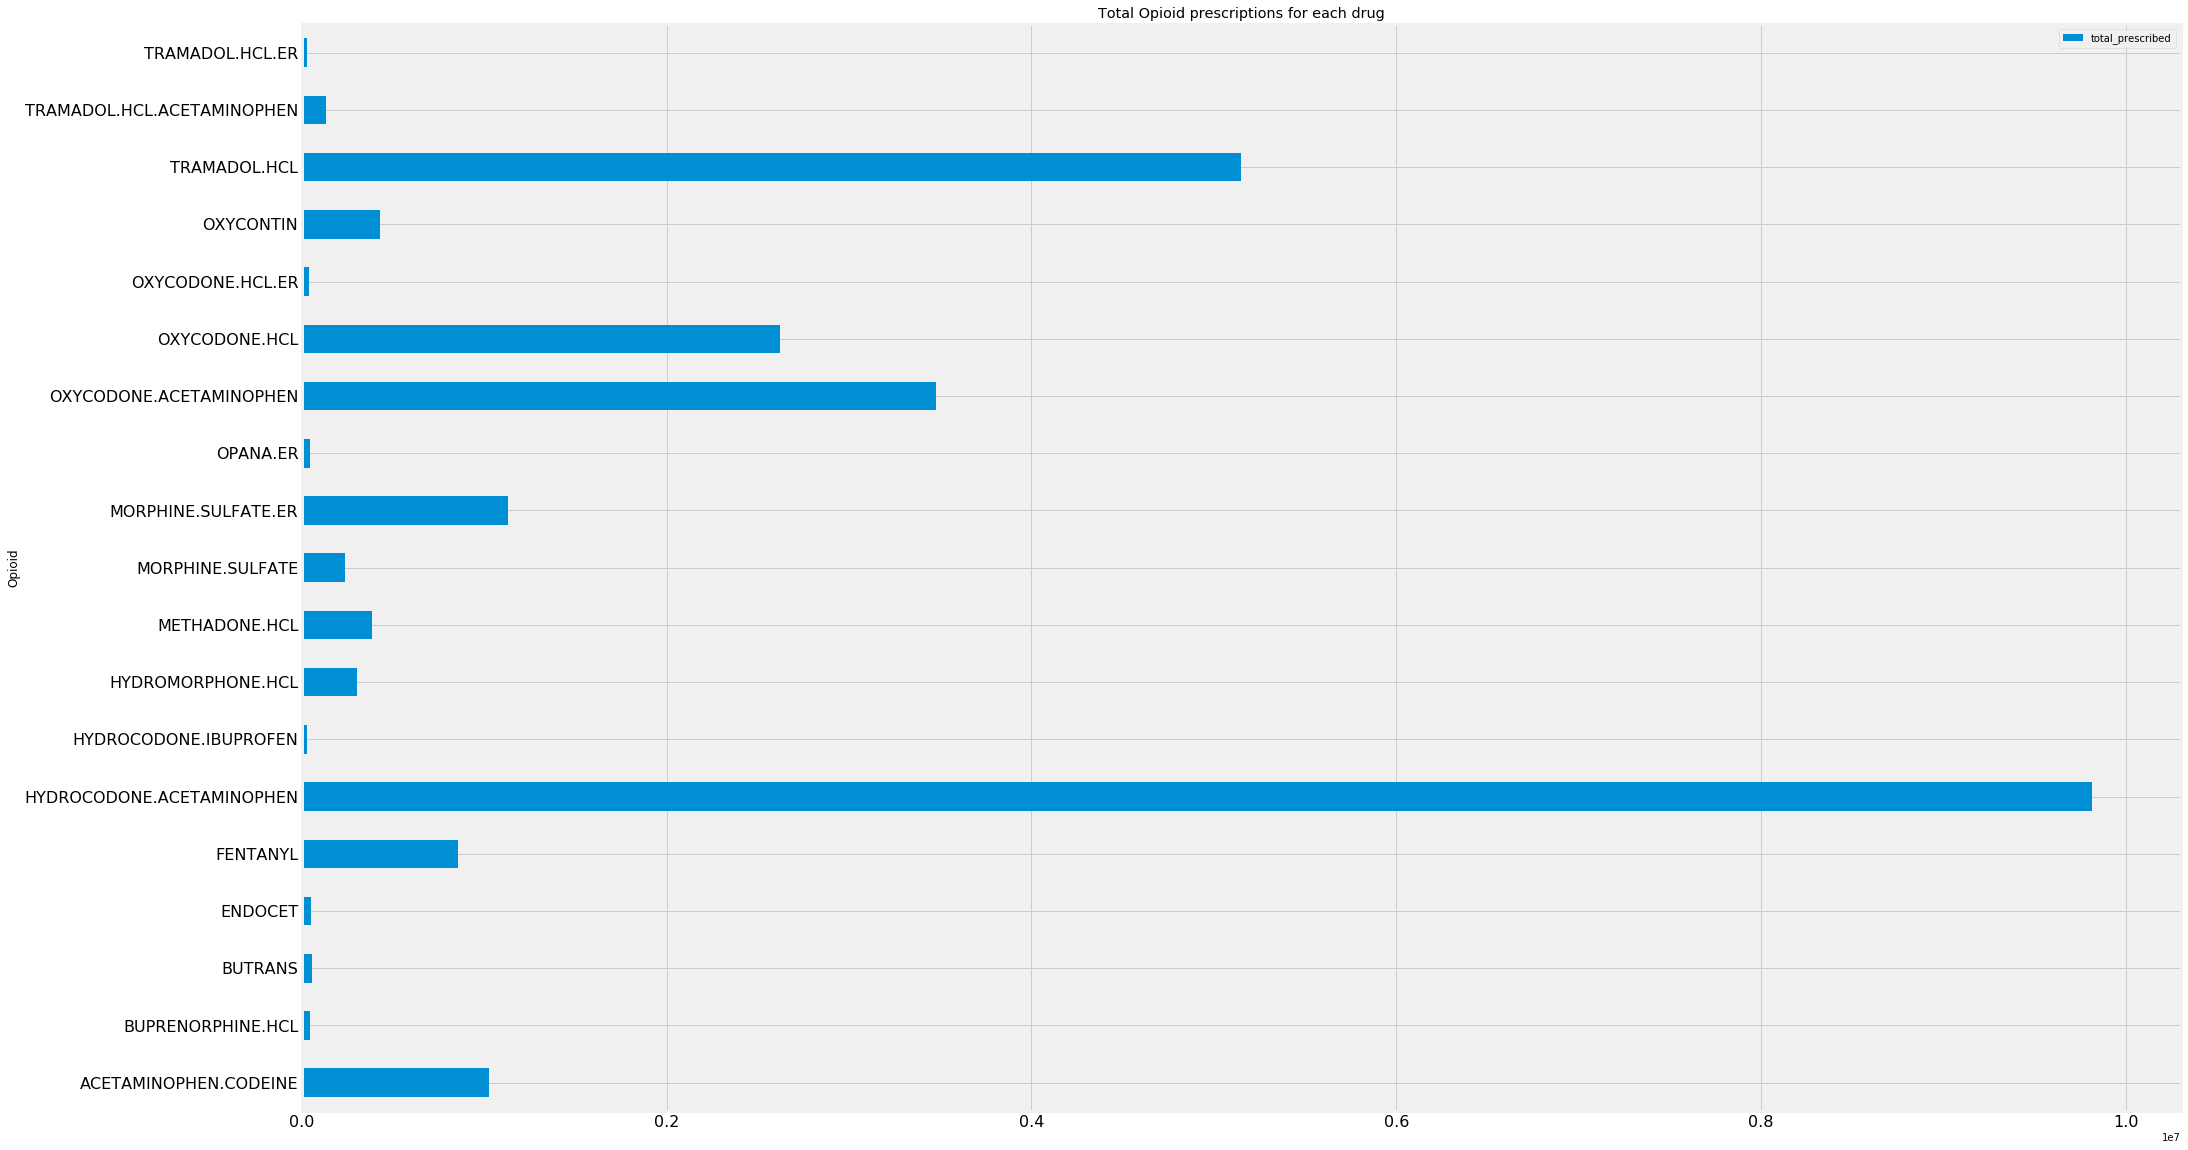

In [23]:
# Sum of each opioid prescription column
dfOpioidSum = dfOpioidsSub.drop(lst_cols_add, axis = 1).sum(axis=0).reset_index() 
dfOpioidSum.columns = ['Opioid', 'total_prescribed']

dfOpioidSumPlot = dfOpioidSum[dfOpioidSum.Opioid != 'total_prescription']
dfOpioidSumPlot.plot.barh(x='Opioid', y='total_prescribed', figsize=(30,20), fontsize=16, title='Total Opioid prescriptions for each drug')

print("---------------------------------------------------")
print("Total for each Opioid Prescription Column")
print("Most prescribed drug: HYDROCODONE.ACETAMINOPHEN")
print("THIS DATASET SEEMS TO ALIGN WITH THE FOLLOWING TRIVIA ON OPIOIDS")
print("Trivia:")
print("""Hydrocodone is used to treat moderate to severe pain due to chronic condition, injury, or surgery. 
      It should only be taken as prescribed by the doctor because of the risk of addiction. 
      Because of the way it’s prescribed, hydrocodone appears more likely to be prescribed 
      compared to other opioids. It’s misused more than any other opioid in the United States. 
      The drug is already banned in European nations due to its abusive tendencies. (healthline.com)""")
print("---------------------------------------------------")

dfOpioidSum.sort_values(['total_prescribed'], ascending=False)

Total Prescription by Specialty & Gender & State:  (6544, 4)
_______________
Merged dataset
_______________
   Population Gender                                      Specialty  \
0     4833722      F                            Allergy/ Immunology   
1     4833722      F                                 Anesthesiology   
2     4833722      F                                     Cardiology   
3     4833722      F            Certified Clinical Nurse Specialist   
4     4833722      F  Certified Registered Nurse Anesthetist (CRNA)   

   total_prescription  
0                   0  
1                1906  
2                  19  
3                   0  
4                   0  
___________________________________________________
Total perscription dispensed relative to population
___________________________________________________
  Gender                                         Specialty  \
0      F                                     Acupuncturist   
1      F                                A

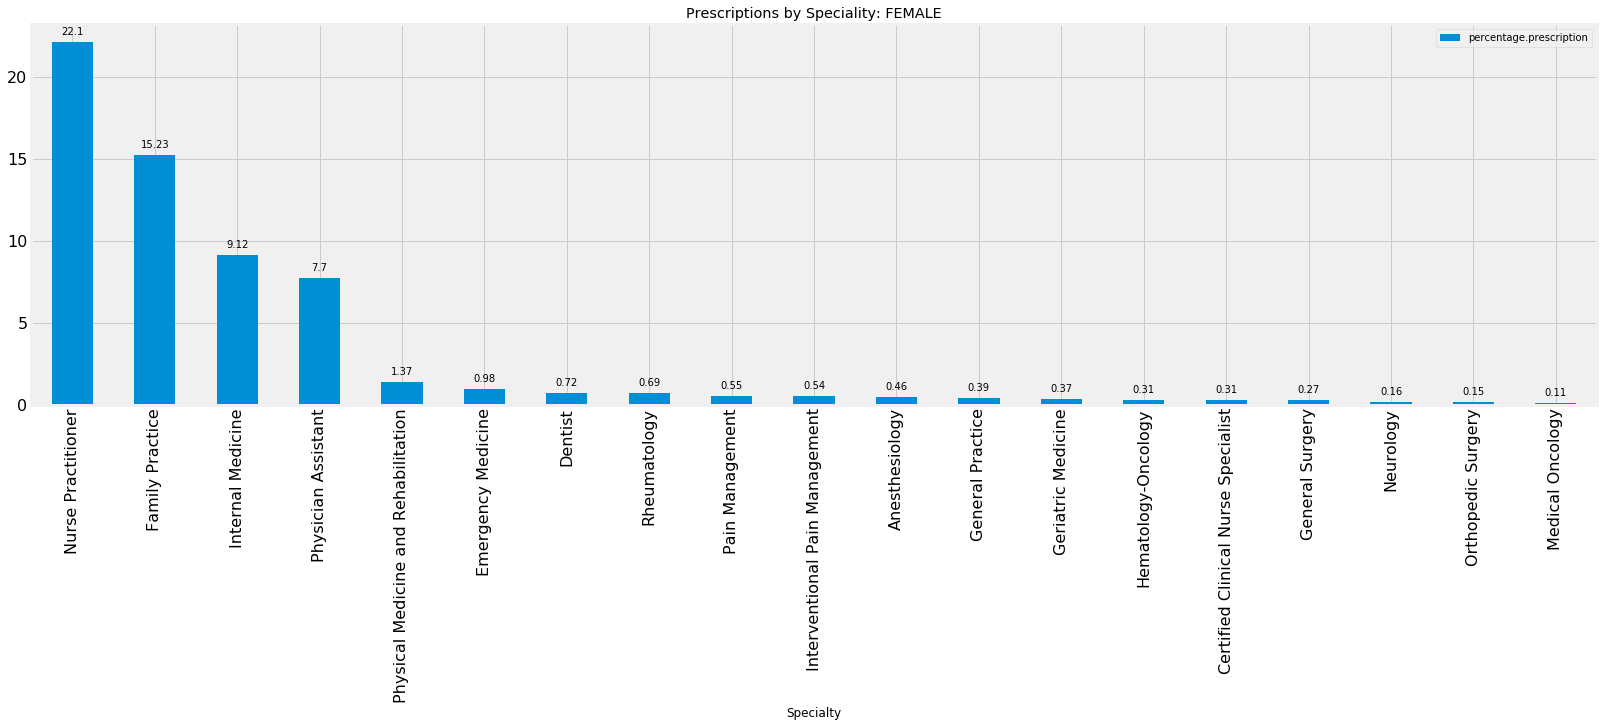

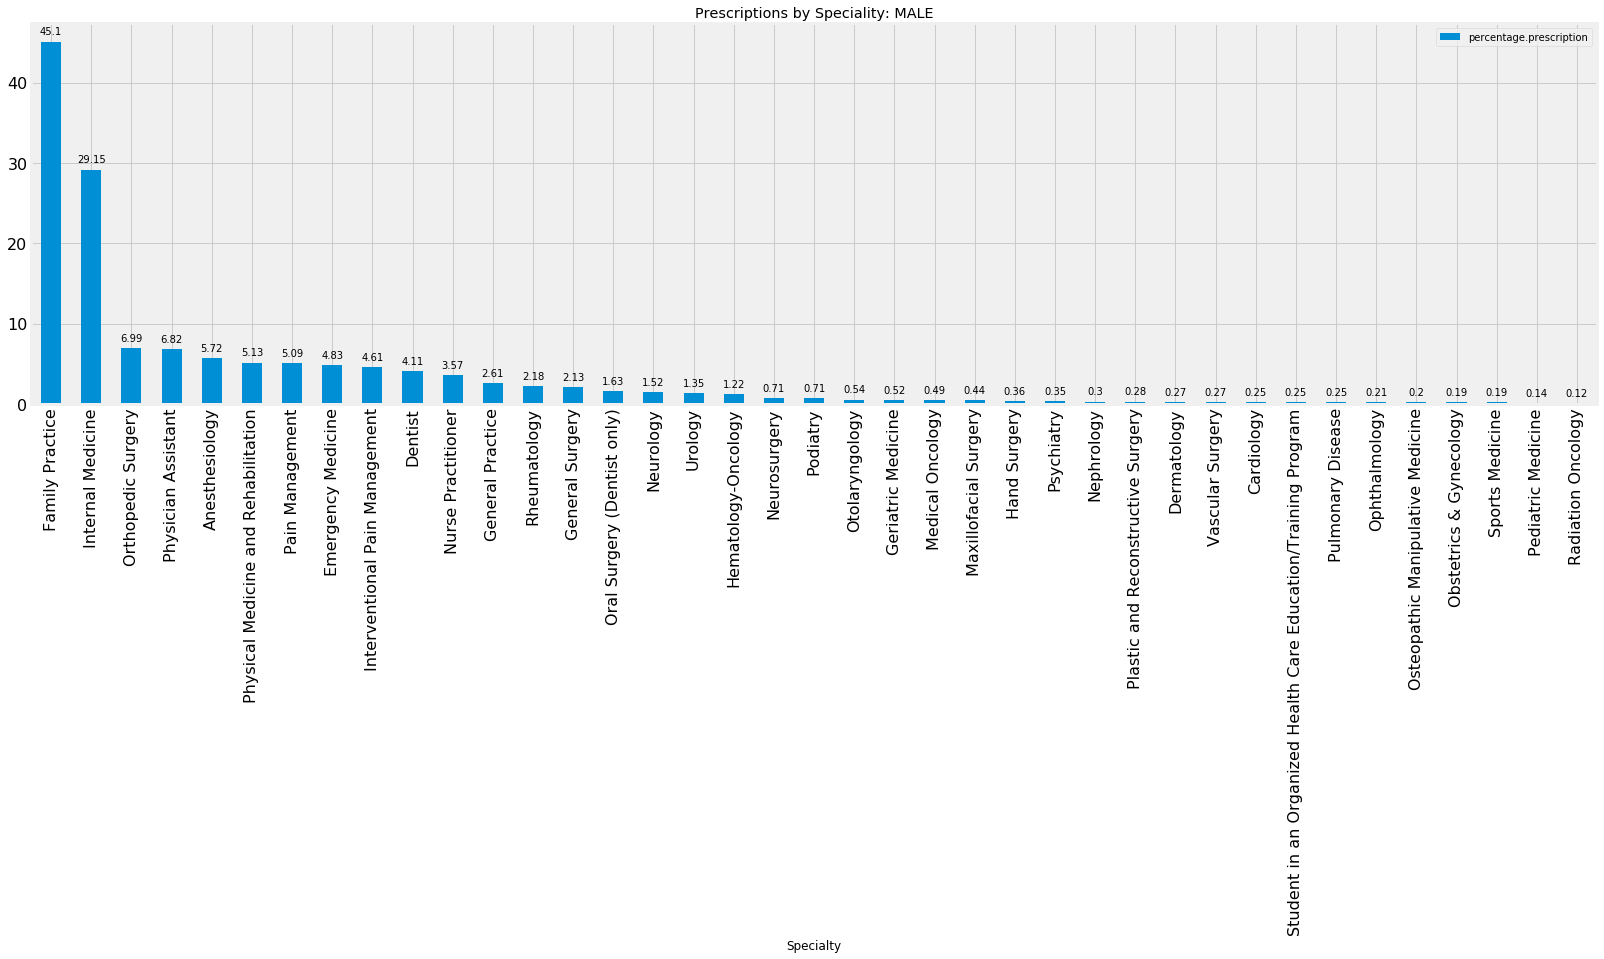

In [24]:
#group by gender and Specialty column
dfPrescriptionsGenderSpecialty = dfOpioidsSub[['Gender', 'Specialty', 'State', 'total_prescription']].groupby(['Gender', 'State', 'Specialty']).sum().reset_index()
print("Total Prescription by Specialty & Gender & State: ", dfPrescriptionsGenderSpecialty.shape)

#print(dfStatePop.iloc[:, 0:2].head())
#print(dfPrescriptionsGenderSpecialty.head())

# merge with population details
dfMerged = dfStatePop.iloc[:, 0:2].merge(dfPrescriptionsGenderSpecialty).drop(['State'], axis= 1)

print("_______________")
print("Merged dataset")
print("_______________")
print(dfMerged.head())

#print(dfTotalPreByGenderSpecialty.head())
dfMerged['percentage.prescription'] =  round((dfMerged.total_prescription * 100) / dfMerged.Population, 2)
dfTotalPreByGenderSpecialty = dfMerged.drop(['total_prescription', 'Population'], axis = 1).groupby(['Gender', 'Specialty']).sum().reset_index()

print("___________________________________________________")
print("Total perscription dispensed relative to population")
print("___________________________________________________")
print(dfTotalPreByGenderSpecialty.head())

#Speciality + Female
dfPrescriptionsSF = dfTotalPreByGenderSpecialty[dfTotalPreByGenderSpecialty['Gender'] == 'F']
print("___________________________________________________")
print("Female prescriptions relative to population")
print(dfPrescriptionsSF.shape)
print("___________________________________________________")
dfFSorted = dfPrescriptionsSF.sort_values(['percentage.prescription'], ascending=False)
print(dfFSorted.head(7))

#Speciality + Male
dfPrescriptionsSM = dfTotalPreByGenderSpecialty[dfTotalPreByGenderSpecialty['Gender'] == 'M']
print("___________________________________________________")
print("Male prescriptions relative to population")
print(dfPrescriptionsSM.shape)
print("___________________________________________________")
dfMSorted = dfPrescriptionsSM.sort_values(['percentage.prescription'], ascending=False)
print(dfMSorted.head(7))

# prescriptions by gender
dfFSorted = dfFSorted[dfFSorted['percentage.prescription'] > 0.1]
ax = dfFSorted.plot(x='Specialty', y='percentage.prescription', kind='bar', figsize=(25,7), fontsize=16, title='Prescriptions by Speciality: FEMALE')
for p in ax.patches:
    b = p.get_bbox()
    val = round(b.y1, 2) 
    ax.annotate(val, ((b.x0 + b.x1)/2, b.y1), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    

dfMSorted = dfMSorted[dfMSorted['percentage.prescription'] > 0.1]
ax = dfMSorted.plot(x='Specialty', y='percentage.prescription', kind='bar', figsize=(25,7), fontsize=16, title='Prescriptions by Speciality: MALE')
for p in ax.patches:
    b = p.get_bbox()
    val = round(b.y1, 2)    
    ax.annotate(val, ((b.x0 + b.x1)/2, b.y1), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')




In [25]:
#How much of the dataset is male vs female
# Grouping by gender and the total sum of prescibers
print("**********************************")
print("Male and Female opioid prescribers")
print("**********************************")
print(dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1].groupby('Gender').size() / dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1].groupby('Gender').size().sum())
print("********************************")
print("Male and Female non opioid prescribers")
print("**********************************")
print(dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 0].groupby('Gender').size() / dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 0].groupby('Gender').size().sum())
print("********************************")
print("Total Male and Female Physicians")
print("********************************")
print(dfPrescriber.groupby('Gender').size()/ dfPrescriber.groupby('Gender').size().sum())
print("*********************************************")
print("Specialities identified as opioid prescribers")
print("*********************************************")
opioidSpecialty = dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1].Specialty.unique()
print(opioidSpecialty)
print("*************************************************")
print("Specialities identified as non opioid prescribers")
print("*************************************************")
nonOpioidSpecialty = dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 0].Specialty.unique()
nonOpioidSpecialty


**********************************
Male and Female opioid prescribers
**********************************
Gender
F    0.384695
M    0.615305
dtype: float64
********************************
Male and Female non opioid prescribers
**********************************
Gender
F    0.457278
M    0.542722
dtype: float64
********************************
Total Male and Female Physicians
********************************
Gender
F    0.419624
M    0.580376
dtype: float64
*********************************************
Specialities identified as opioid prescribers
*********************************************
['Internal Medicine' 'Nurse Practitioner' 'Neurology' 'Emergency Medicine'
 'Family Practice' 'Dentist' 'Oral Surgery (Dentist only)'
 'Student in an Organized Health Care Education/Training Program'
 'Hematology-Oncology' 'Ophthalmology' 'General Surgery' 'Otolaryngology'
 'Podiatry' 'Physician Assistant' 'Gastroenterology' 'Hospitalist'
 'Orthopaedic Surgery' 'Rheumatology' 'Orthopedic Surgery'
 

array(['Nurse Practitioner', 'Dentist',
       'Physical Medicine and Rehabilitation', 'Obstetrics & Gynecology',
       'Family Practice',
       'Student in an Organized Health Care Education/Training Program',
       'Optometry', 'Infectious Disease', 'Dermatology',
       'Oral Surgery (Dentist only)', 'Psychiatry & Neurology',
       'Anesthesiology', 'Rheumatology', 'Internal Medicine',
       'General Surgery', 'Cardiology', 'Pharmacist', 'Gastroenterology',
       'Physician Assistant', 'Pediatric Medicine', 'Ophthalmology',
       'Nephrology', 'Psychiatry', 'Clinical Cardiac Electrophysiology',
       'Otolaryngology', 'Urology', 'General Practice', 'Neuropsychiatry',
       'Radiation Oncology', 'Pulmonary Disease',
       'Certified Clinical Nurse Specialist', 'Specialist',
       'Undefined Physician type', 'Interventional Cardiology',
       'Hospitalist', 'Hematology-Oncology', 'Neurology',
       'General Acute Care Hospital', 'Pathology', 'Endocrinology',
       'Surge

In [26]:
print("*********************************************")
print("Specialties where Opioid Prescription column is 0 in all instances")
print("*********************************************")
non_opioid_list = list(set(nonOpioidSpecialty)-set(opioidSpecialty))
print(len(non_opioid_list))
pd.DataFrame(non_opioid_list).head(50)

*********************************************
Specialties where Opioid Prescription column is 0 in all instances
*********************************************
43


,0
0,Registered Dietitian or Nutrition Professional
1,Occupational Therapist in Private Practice
2,Point of Service
3,Chore Provider
4,Naprapath
5,"Sleep Specialist, PhD"
6,Nutritionist
7,Contractor
8,Hospital
9,"Respiratory Therapist, Registered"


In [27]:
print("*********************************************************")
print('Specialty count to see if there is an even spread in data')
print("*********************************************************")
dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1].groupby('Specialty').size()

*********************************************************
Specialty count to see if there is an even spread in data
*********************************************************


Specialty
Acupuncturist                                                         1
Addiction Medicine                                                   29
Allergy/ Immunology                                                  53
Ambulatory Surgical Center                                            1
Anesthesiology                                                     1161
Assistant, Podiatric                                                  1
Cardiac Surgery                                                     175
Cardiology                                                         1094
Case Manager/Care Coordinator                                         1
Certified Clinical Nurse Specialist                                 154
Certified Nurse Midwife                                              11
Certified Registered Nurse Anesthetist (CRNA)                        12
Chiropractic                                                          2
Chronic Disease Hospital                              

In [28]:
print("******************************************************************************************************")
print("Total number of population representation for the specialties where target column is 0 in all instance")
print("******************************************************************************************************")
dfPrescriber[dfPrescriber['Specialty'].isin(non_opioid_list)].groupby('Specialty').size()

******************************************************************************************************
Total number of population representation for the specialties where target column is 0 in all instance
******************************************************************************************************


Specialty
Advanced Heart Failure and Transplant Cardiology     5
Advanced Practice Dental Therapist                   2
Anesthesiology Assistant                             1
Behavior Analyst                                     2
Chore Provider                                       2
Clinical Neuropsychologist                           3
Clinical Pharmacology                                3
Contractor                                           2
Dental Hygienist                                     2
Developmental Therapist                              2
Emergency Medical Technician, Basic                  2
Health Educator                                      1
Health Maintenance Organization                      1
Hearing Instrument Specialist                        1
Hospital                                            11
Licensed Clinical Social Worker                     18
Marriage & Family Therapist                          1
Mechanotherapist                                     2


In [29]:
# Opioid prescriber vs non prescriber
# Score seems to indicate that it is not an imbalanced data set
# 41.28% are non prescribers
# 58.71% are prescribers
print("---------------------------------------------")
print("% of Opioid Prescribers vs  did not opioid prescibers")
print("---------------------------------------------")
count_not_opioid = len(dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 0])
count_opioid = len(dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1])
pct_of_not_opioid = count_not_opioid/(count_not_opioid + count_opioid)
print("percentage of non opioid prescribers ", pct_of_not_opioid * 100)
pct_of_opioid = count_opioid/(count_not_opioid + count_opioid)
print("percentage of opioid prescribers ", pct_of_opioid * 100)
#print(dfPrescriber.groupby('Opioid.Prescriber').size() / dfPrescriber.groupby('Opioid.Prescriber').size().sum())
print(dfPrescriber.shape)

# Drop columns not required- credentials is the abbreviated form of specialty
dfPrescriber = dfPrescriber.drop(['npi', 'Credentials'], axis = 1)



---------------------------------------------
% of Opioid Prescribers vs  did not opioid prescibers
---------------------------------------------
percentage of non opioid prescribers  48.123451591598
percentage of opioid prescribers  51.876548408402
(346727, 606)


Not Opioid Prescribers:  166857
Opioid Prescribers:  179870


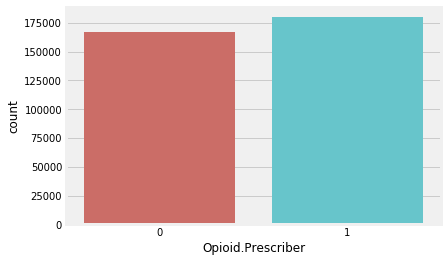

In [30]:
# Plotting the target variable
#print(dfPrescriber.Opioid.Prescriber.value_counts())
# We have more opioid prescribers in the data set and non opioid prescribers
# The data is horribly imbalanced for the train and test split
print("Not Opioid Prescribers: " , count_not_opioid)
print("Opioid Prescribers: " , count_opioid)
sns.countplot(x = 'Opioid.Prescriber', data = dfPrescriber, palette = 'hls')
plt.show()

In [31]:
import re
# Remove spaces as it is the column name 
# Matching name in opioid file with the column names in prescriber.csv AMIODARONE.HCL
opioid_name = dfOpioids['drug_name'].apply(lambda x:re.sub("\ |-", ".", str(x)))
#for s in opioid_name:
    #print(s)

# Opioid prescriber tells us if the doctor prescribes opioids
# Data set contains columns that are both opioids and non opioids 
# remove non opioid columns from the prescription dataset
columns = dfPrescriber.columns
remove_cols = set(columns).intersection(set(opioid_name))
    
non_opioid_cols=[]
for col in columns:
    if col in remove_cols:
        pass
    else:
        non_opioid_cols.append(col)
        
print(list(non_opioid_cols))




['Gender', 'State', 'Specialty', 'ABILIFY.MAINTENA', 'ACARBOSE', 'ACETAZOLAMIDE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'ADVAIR.HFA', 'ALBUTEROL.SULFATE', 'ALCOHOL.PADS', 'ALCOHOL.PREP.PADS', 'ALENDRONATE.SODIUM', 'ALFUZOSIN.HCL.ER', 'ALLOPURINOL', 'ALPHAGAN.P', 'ALPRAZOLAM', 'AMANTADINE', 'AMIODARONE.HCL', 'AMITIZA', 'AMITRIPTYLINE.HCL', 'AMLODIPINE.BESYLATE', 'AMLODIPINE.BESYLATE.BENAZEPRIL', 'AMLODIPINE.OLMESARTAN', 'AMLODIPINE.VALSARTAN', 'AMMONIUM.LACTATE', 'AMOXICILLIN', 'AMOXICILLIN.CLAVULANATE.POTASS', 'ANASTROZOLE', 'ANDROGEL', 'ANORO.ELLIPTA', 'APRISO', 'ARIPIPRAZOLE', 'ARMOUR.THYROID', 'ARNUITY.ELLIPTA', 'ASMANEX', 'ASPIRIN.DIPYRIDAMOLE.ER', 'ATENOLOL', 'ATENOLOL.CHLORTHALIDONE', 'ATORVASTATIN.CALCIUM', 'ATRIPLA', 'ATROVENT.HFA', 'AUTOSHIELD.DUO.PEN.NEEDLE', 'AZATHIOPRINE', 'AZELASTINE.HCL', 'AZITHROMYCIN', 'AZOPT', 'BACLOFEN', 'BALSALAZIDE.DISODIUM', 'BD.ULTRA.FINE.PEN.NEEDLE', 'BELSOMRA', 'BENAZEPRIL.HCL', 'BENAZEPRIL.HYDROCHLOROTHIAZIDE', 'BENICAR', 'BENICAR.HCT', 'BENZTROPINE.ME

In [32]:
dfPrescriber.shape

(346727, 604)

In [33]:
print("Selected columns")
print("""
# Gender
# Speciality
# State
# non opioid drugs
    # the lists comprises of drugs typically used for the treatment of chronic or acute conditions associated 
    # with pain symptoms such as body aches, heart burn, arthritis or HIV to name a few
    # Non opioid drugs include:
    ## ACYCLOVIR: Used for herpes virus infections or shingles and also used by HIV patients for the treatment of infections
    ## DIAZEPAM: Subdues anxiety, muscle spasms, and seizures
    ## LAMOTRIGINE: Bipolar disorder
    ## IBUPROFEN: Used to quell severe pain
    ## FAMOTIDINE: Used for the treatment of ulcers, gastroesophageal reflux disease
    ## LIDOCAINE: Relieves pain and numbs skin (analgesic)
    etc ..........""")
print("_________________________________________________")
print("Rejected Columns")
print("""
# Credentials: Similar to Specialty
# Opioid Prescription details and drugs- seems to create models with 100% I assume this is a data leak column?
# npi- seems to be a primary key- column irrelevant for analytics""")

df = dfPrescriber[non_opioid_cols]
print(df.shape)

# Convert categorical columns to numeric values
cat_columns=['Gender','State','Specialty']

# Scores by dropping all of opioids prescriptions
for col in cat_columns:
    df[col]= pd.factorize(df[col], sort=True)[0]

# Scores by retaining all of opioids prescriptions is much higher so keeping the opioid columns
for col in cat_columns:
    dfPrescriber[col]= pd.factorize(df[col], sort=True)[0]

print("Converting string values to continuous numeric values via factorization")
df.head()

Selected columns

# Gender
# Speciality
# State
# non opioid drugs
    # the lists comprises of drugs typically used for the treatment of chronic or acute conditions associated 
    # with pain symptoms such as body aches, heart burn, arthritis or HIV to name a few
    # Non opioid drugs include:
    ## ACYCLOVIR: Used for herpes virus infections or shingles and also used by HIV patients for the treatment of infections
    ## DIAZEPAM: Subdues anxiety, muscle spasms, and seizures
    ## LAMOTRIGINE: Bipolar disorder
    ## IBUPROFEN: Used to quell severe pain
    ## FAMOTIDINE: Used for the treatment of ulcers, gastroesophageal reflux disease
    ## LIDOCAINE: Relieves pain and numbs skin (analgesic)
    etc ..........
_________________________________________________
Rejected Columns

# Credentials: Similar to Specialty
# Opioid Prescription details and drugs- seems to create models with 100% I assume this is a data leak column?
# npi- seems to be a primary key- column irrelevant for 

,Gender,State,Specialty,ABILIFY.MAINTENA,ACARBOSE,ACETAZOLAMIDE,ACYCLOVIR,ADVAIR.DISKUS,ADVAIR.HFA,ALBUTEROL.SULFATE,...,XOPENEX.HFA,YUVAFEM,ZALEPLON,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,ZOLPIDEM.TARTRATE.ER,ZONISAMIDE,ZOSTAVAX,Opioid.Prescriber
0,0,12,86,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,6,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,51,108,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,38,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,51,88,0,0,0,0,0,0,0,...,0,13,0,0,0,0,0,0,0,0


In [34]:
# Split the data to testing and training sets (test => 30%, train => 70%)
# This is a very sensitive model so we will proceed to create a balanceed Test-Train split of 50% 
#!pip install imblearn 
from imblearn.over_sampling import SMOTE
target_col = ['Opioid.Prescriber']

# Limit data to 50% so that analysis can run on RAM and efficiently
print("100% of the data set: ", df.shape)
n = 25
df = df.head(int(len(df)*(n/100)))
print("25% of the data set: ", df.shape)

# Gender Included
X = df.drop(target_col, axis = 1)
# Removing gender increases prediction score- very low correlation between gender and opioid prescription
Y = df[target_col]

#Split the dataset as test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#Check the numbers of data
print("******************************************************************")
print("Test-Train split before Synthetic Minority Over-sampling Technique")
print("******************************************************************")
print("length of oversampled data is: ", len(X_train))
print("Number of non opioid prescriber in oversampled data: ", len(Y_train[Y_train['Opioid.Prescriber'] == 0]))
print("Number of opioid prescriber: ", len(Y_train[Y_train['Opioid.Prescriber'] == 1]))
print("Proportion of non opioid prescibers in sample: ", round(len(Y_train[Y_train['Opioid.Prescriber'] == 0])/len(X_train), 2))
print("Proportion of opioid prescriber data in sample:  ", round(len(Y_train[Y_train['Opioid.Prescriber'] == 1])/len(X_train), 2))

#Synthetic Minority Over-sampling Technique to balance the dataset
sm = SMOTE(random_state = 42)
columns = X_train.columns
smX_train, smY_train = sm.fit_sample(X_train, Y_train.values.ravel())
# convert numpy array back to dataframe
X_train = pd.DataFrame(data = smX_train, columns=columns )
Y_train = pd.DataFrame(data = smY_train, columns=target_col)

#Check the numbers of data
print("*****************************************************************")
print("Test-Train split after Synthetic Minority Over-sampling Technique")
print("*****************************************************************")
print("length of oversampled data is: ", len(X_train))
print("Number of non opioid prescriber in oversampled data: ", len(Y_train[Y_train['Opioid.Prescriber'] == 0]))
print("Number of opioid prescriber: ", len(Y_train[Y_train['Opioid.Prescriber'] == 1]))
print("Proportion of no opioid prescibers in sample: ", len(Y_train[Y_train['Opioid.Prescriber'] == 0])/len(X_train))
print("Proportion of opioid prescriber data in sample:  ", len(Y_train[Y_train['Opioid.Prescriber'] == 1])/len(X_train))


Using TensorFlow backend.


100% of the data set:  (346727, 585)
25% of the data set:  (86681, 585)
******************************************************************
Test-Train split before Synthetic Minority Over-sampling Technique
******************************************************************
length of oversampled data is:  60676
Number of non opioid prescriber in oversampled data:  29023
Number of opioid prescriber:  31653
Proportion of non opioid prescibers in sample:  0.48
Proportion of opioid prescriber data in sample:   0.52
*****************************************************************
Test-Train split after Synthetic Minority Over-sampling Technique
*****************************************************************
length of oversampled data is:  63306
Number of non opioid prescriber in oversampled data:  31653
Number of opioid prescriber:  31653
Proportion of no opioid prescibers in sample:  0.5
Proportion of opioid prescriber data in sample:   0.5


Predicts the likelihood that a certain type of doctor prescribes opioids
--------------------------
Logistic Regression
--------------------------
[[11106  1485]
 [ 4731  8683]]


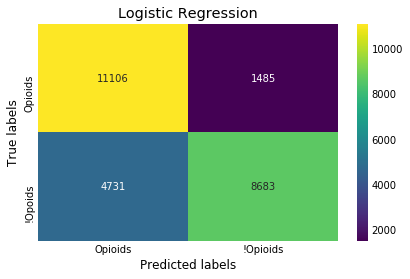

--------------------------
Random forest classifier
--------------------------
[[10505  2086]
 [ 2592 10822]]


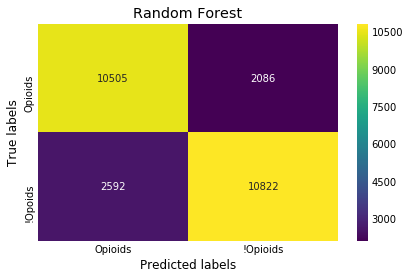

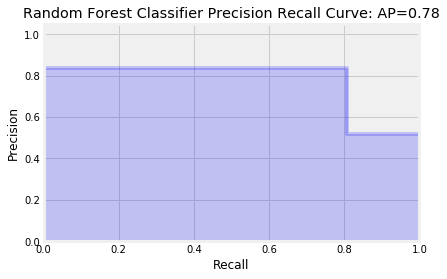

--------------------------
Decision Tree Classifier
--------------------------
[[ 9578  3013]
 [ 2854 10560]]


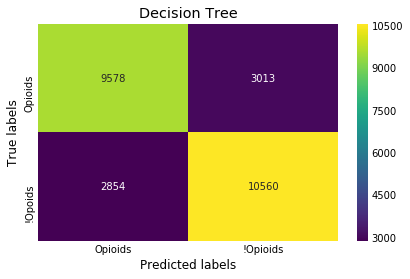

--------------------------
Gaussian Naive Bayes
--------------------------
[[11650   941]
 [ 8691  4723]]


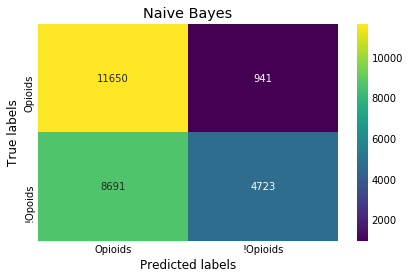

--------------------------
Gradient Boosting
--------------------------
[[10942  1649]
 [ 3144 10270]]


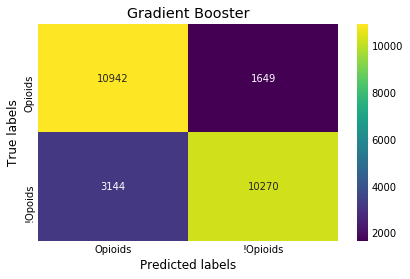

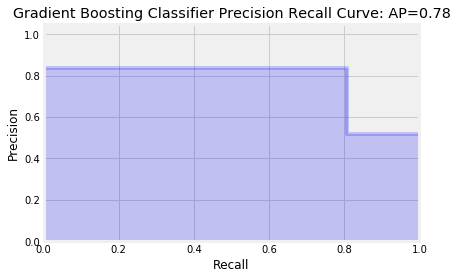

--------------------------
KNN
--------------------------
[[10225  2366]
 [ 3261 10153]]


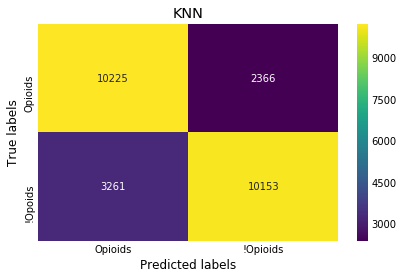

--------------------------
Linear Discriminant
--------------------------
[[11395  1196]
 [ 5855  7559]]


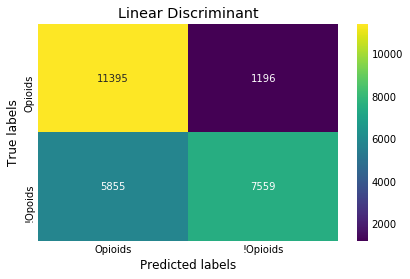

--------------------------
Bagging Classifier
--------------------------
[[10210  2381]
 [ 2676 10738]]


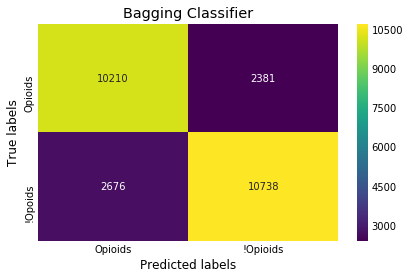

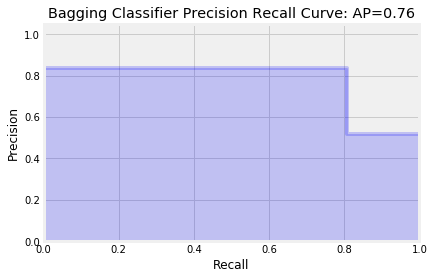

,Evaluation Metrics,Score,Algorithm
0,Accuracy Score,0.760969,Logistic Regression
1,Recall Score,0.647309,Logistic Regression
2,Average precision Score,0.734698,Logistic Regression
3,F1 Score,"[0.781342338539468, 0.7364091256042745]",Logistic Regression
0,Accuracy Score,0.820112,Random Forest Classifier
1,Recall Score,0.806769,Random Forest Classifier
2,Average precision Score,0.776064,Random Forest Classifier
3,F1 Score,"[0.8178916225474929, 0.8222779424055923]",Random Forest Classifier
0,Accuracy Score,0.77439,Decision Tree Classifier
1,Recall Score,0.787237,Decision Tree Classifier


In [35]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, average_precision_score, f1_score
from sklearn.metrics import precision_recall_curve

print("Predicts the likelihood that a certain type of doctor prescribes opioids")

# calling the classification algorithms for predictions
#Logistic regression
print("--------------------------")
print("Logistic Regression")
print("--------------------------")
lr = LogisticRegression(random_state=0, solver='liblinear', max_iter=1500)
lrmodel = lr.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_lr = lrmodel.predict(X_test)

accuracyscore = accuracy_score(Y_test.values, Y_predict_lr)
recallscore = recall_score(Y_test.values, Y_predict_lr)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_lr)
f1score = f1_score(Y_test.values, Y_predict_lr, average = None)
                   
data = [['Accuracy Score', accuracyscore, 'Logistic Regression'], 
        ['Recall Score', recallscore, 'Logistic Regression'], 
        ['Average precision Score', avgprecisionscore, 'Logistic Regression'],
        ['F1 Score', f1score, 'Logistic Regression']] 
# Create the pandas DataFrame 
dflr = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 
  
cm = confusion_matrix(Y_test, Y_predict_lr)
# Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. 
# In the output, 2565 and 3111 are actual predictions, and 502 and 1250 are incorrect predictions.
#[True Negatives        False Positives 
# False Negatives       True Positives]
#TP: the cases for which the classifier algorithm predicted ‘overdosing prescriber’ which was correct.
#TN: the cases for which the classifier predicted ‘not an overdose prescriber’ and it wasn't an overdosing prescriber
#FP: the cases for which the classifier predicted ‘overdosing prescriber’ but the it wasn't.
#FN: the cases for which the classifier predicted ‘not an overdosing prescriber’ but the emails were actually overdosing prescribers.
print(cm)
#Plot the confusion matrix
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g'); 
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()


#Random forest classifier
print("--------------------------")
print("Random forest classifier")
print("--------------------------")
rfmodel = RandomForestClassifier()
rfmodel.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_rf = rfmodel.predict(X_test)
#print("Accuracy score: ", rfmodel.score(X_test, Y_test))
accuracyscore = accuracy_score(Y_test.values, Y_predict_rf)
recallscore = recall_score(Y_test.values, Y_predict_rf)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_rf)
f1score = f1_score(Y_test.values, Y_predict_rf, average = None)
                                      
data = [['Accuracy Score', accuracyscore, 'Random Forest Classifier'], 
        ['Recall Score', recallscore, 'Random Forest Classifier'], 
        ['Average precision Score', avgprecisionscore, 'Random Forest Classifier'],
        ['F1 Score', f1score, 'Random Forest Classifier']] 
# Create the pandas DataFrame 
dfrf = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_rf)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Random Forest'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()

# Precision Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, Y_predict_rf)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Random Forest Classifier Precision Recall Curve: AP={0:0.2f}'.format(avgprecisionscore))
plt.show()


#Decision Tree Classifier
print("--------------------------")
print("Decision Tree Classifier")
print("--------------------------")
dt = DecisionTreeClassifier(random_state=12)
dtmodel = dt.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_dt = dtmodel.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_dt)
recallscore = recall_score(Y_test.values, Y_predict_dt)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_dt)
f1score = f1_score(Y_test.values, Y_predict_dt, average = None)
                   
data = [['Accuracy Score', accuracyscore, 'Decision Tree Classifier'], 
        ['Recall Score', recallscore, 'Decision Tree Classifier'], 
        ['Average precision Score', avgprecisionscore, 'Decision Tree Classifier'],
        ['F1 Score', f1score, 'Decision Tree Classifier']] 
# Create the pandas DataFrame 
dfdt = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_dt)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis", fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Decision Tree'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()



#Naive bayes
print("--------------------------")
print("Gaussian Naive Bayes")
print("--------------------------")
gnb = GaussianNB()
modelgnb = gnb.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_nb = modelgnb.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_nb)
recallscore = recall_score(Y_test.values, Y_predict_nb)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_nb)
f1score = f1_score(Y_test.values, Y_predict_nb, average = None)
                   
data = [['Accuracy Score', accuracyscore, 'Naive Bayes'], 
        ['Recall Score', recallscore, 'Naive Bayes'], 
        ['Average precision Score', avgprecisionscore, 'Naive Bayes'],
        ['F1 Score', f1score, 'Niave Bayes']] 
# Create the pandas DataFrame 
dfnb = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_nb)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Naive Bayes'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()



# Gradient Boosting
print("--------------------------")
print("Gradient Boosting")
print("--------------------------")
gb = GradientBoostingClassifier(n_estimators=200)
modelgb = gb.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_gb = modelgb.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_gb)
recallscore = recall_score(Y_test.values, Y_predict_gb)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_gb)
f1score = f1_score(Y_test.values, Y_predict_gb, average = None)
                   
data = [['Accuracy Score', accuracyscore, 'Gradient Boosting'], 
        ['Recall Score', recallscore, 'Gradient Boosting'], 
        ['Average precision Score', avgprecisionscore, 'Gradient Boosting'],
        ['F1 Score', f1score, 'Gradient Boosting']] 
# Create the pandas DataFrame 
dfgb = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_gb)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Gradient Booster'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()

# Precision Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, Y_predict_rf)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Gradient Boosting Classifier Precision Recall Curve: AP={0:0.2f}'.format(avgprecisionscore))
plt.show()


# KNN
print("--------------------------")
print("KNN")
print("--------------------------")
# Avoiding overfitting issue with Principle Dimensinality reduction to see if the model score improves

knn = KNeighborsClassifier(n_neighbors=5)
modelknn = knn.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_knn = modelknn.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_knn)
recallscore = recall_score(Y_test.values, Y_predict_knn)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_knn)
f1score = f1_score(Y_test.values, Y_predict_knn, average = None)
                   
data = [['Accuracy Score', accuracyscore, 'KNN'], 
        ['Recall Score', recallscore, 'KNN'], 
        ['Average precision Score', avgprecisionscore, 'KNN'],
        ['F1 Score', f1score, 'KNN']] 
# Create the pandas DataFrame 
dfknn = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_knn)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('KNN'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()



# Linear Discriminant
print("--------------------------")
print("Linear Discriminant")
print("--------------------------")
ld = LinearDiscriminantAnalysis()
modelld = ld.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_ld = modelld.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_ld)
recallscore = recall_score(Y_test.values, Y_predict_ld)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_ld)
f1score = f1_score(Y_test.values, Y_predict_ld, average = None)
                   
data = [['Accuracy Score', accuracyscore, 'Linear Discriminant'], 
        ['Recall Score', recallscore, 'Linear Discriminant'], 
        ['Average precision Score', avgprecisionscore, 'Linear Discriminant'],
        ['F1 Score', f1score, 'Linear Discriminant']] 
# Create the pandas DataFrame 
dfld = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_ld)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g'); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Linear Discriminant'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()


# Bagging Classifier
print("--------------------------")
print("Bagging Classifier")
print("--------------------------")
bc = BaggingClassifier()
modelbc = bc.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_bc = modelbc.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_bc)
recallscore = recall_score(Y_test.values, Y_predict_bc)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_bc)
f1score = f1_score(Y_test.values, Y_predict_bc, average = None)
                   
data = [['Accuracy Score', accuracyscore, 'Bagging Classifier'], 
        ['Recall Score', recallscore, 'Bagging Classifier'], 
        ['Average precision Score', avgprecisionscore, 'Bagging Classifier'],
        ['F1 Score', f1score, 'Bagging Classifier']] 
# Create the pandas DataFrame 
dfbc = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm'])  

cm = confusion_matrix(Y_test, Y_predict_bc)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Bagging Classifier'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()

# Precision Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, Y_predict_rf)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Bagging Classifier Precision Recall Curve: AP={0:0.2f}'.format(avgprecisionscore))
plt.show()


# Precision recall graph
# A line across the middle indicates 50% probabilty 
# A line below that middle line indicates poor performance 
# Line above the middle line indicates better quality.
# 100 implies complete accuracy 0 implies horrible performance

# precision-recall to help determine the success of the trial.
# true positive, true negative, false positive, and false negative. 
# The more successful a model is, the less false positives and false negatives and more true positives and true negatives. 
# The precision-recall score represents this total, and the precision-recall curve helps to visualize it.

# Best results from - Random Forest, Gradient Boosting, Bagging Classifier
frames = [dflr, dfrf, dfdt, dfnb, dfgb, dfknn, dfld, dfbc]
result = pd.concat(frames)
result


In [36]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='modified_huber', shuffle=True, random_state = 141)
sgd.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_sgd = sgd.predict(X_test)

accuracyscore = accuracy_score(Y_test.values, Y_predict_sgd)
recallscore = recall_score(Y_test.values, Y_predict_sgd)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_sgd)
accuracyscore

0.7157854258796386